# Assignment 1. Data Manipulation and Visualization  

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2024)*  

*For your questions refer to mehrshadtaji61@gmail.com or @m522t on Telegram*

### Description
In this homework you are supposed to get comfortable (or make sure that you are!) with the basic Python tools frequently used in data science.  

### Information  
Complete the information box below.

In [1]:
full_name = "Pantea"
student_id = "Amoie"

### Import necessary packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as ss
import re
import string


# 1. Let's Talk Business!

Storing customer and transaction data is crucial for e-commerce businesses as it enables them to understand and anticipate customer needs, optimize operations, and enhance the overall shopping experience. By collecting and analyzing data such as purchase history, browsing behavior, and demographic information, e-commerce platforms can personalize marketing efforts, recommend products, and improve customer retention. Additionally, transaction data helps in managing inventory, detecting fraudulent activities, and ensuring secure payment processing

This dataset contains the official transactions and customer data for a certain E-Commerce. The schema of the dataset can be shown in the following diagram.

<div style="text-align: center;">
<img src="./data/Q1/commerce_schema.png" alt="commerce-schema" width="750"/>
</div>

In this task you have to apply the following Data Wrangling pipeline:
* Load your data into `Pandas`  

* Explore it and clean its dirty parts
* Use it to answer a set of queries

Each of these subtasks are described in detail below.

## 1.1 Loading Phase

Load all of the sheets in the excel file to multiple `Pandas` dataframes in the directory `data/Q1`

In [4]:
# (I used google colab, so I didn't need the "data/Q1" part of the directory)
file_path = 'E-commerce_data.xlsx'
df_sheets = pd.read_excel(file_path, sheet_name=None)
print(df_sheets.keys())

dict_keys(['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants'])


## 1.2 Cleaning Phase

Explore the following columns from your dataset:

* transactions: year  

* transactions: branch_id
  
Answer the following questions using data visualizations and manipulations. The code for this part is required alongside your explanations either in comments or markdown.  

1. What is the time range of the transactions?  
2. What is the median branch in terms of transaction count?
3. Do you see any inconsistencies?
4. Provide code that detects and cleans such inconsistencies and validates the coherence of your dataset.

In [5]:
# Exploring the columns(year):

df_transactions = df_sheets['transactions']
# Converting the date data to date-time object using pd.to_datetime
df_transactions['year'] = pd.to_datetime(df_transactions['transaction_date'], errors='coerce').dt.year
print(df_transactions['year'])

0       2024.0
1       2023.0
2       2022.0
3          NaN
4       2022.0
         ...  
4995    2024.0
4996    2024.0
4997    2022.0
4998    2024.0
4999    2022.0
Name: year, Length: 5000, dtype: float64


In [6]:
# Exploring the columns(branch_id):

print(df_transactions['branch_id'])

0       7.0
1       5.0
2       7.0
3       2.0
4       6.0
       ... 
4995    1.0
4996    2.0
4997    2.0
4998    7.0
4999    6.0
Name: branch_id, Length: 5000, dtype: float64


In [7]:
# Q1:

# Time range in years only:
# time_range = (df_transactions['year'].min(), df_transactions['year'].max())
# print(f"Time range is from {time_range[0]} to {time_range[1]}")

# Time range in full date:
full_date_range = (df_transactions['transaction_date'].min(), df_transactions['transaction_date'].max())
print(f"Full date range is from {full_date_range[0]} to {full_date_range[1]}")

Full date range is from 2021-08-05 to 20240-07-11


In [8]:
# Q2:
# Median branch in terms of transaction count

# Finding the exact median
num_trans_per_branch = df_transactions['branch_id'].value_counts()
median_branch_count = num_trans_per_branch.median()
print(f"Median of transaction count per branch is {median_branch_count}")

# This is because the total number of branches is even, so the average of the two center values is the actual median
# But because we need to suggest a branch_id as the median we can do this:

sorted_branches = num_trans_per_branch.sort_values(ascending=False)
median_index = len(sorted_branches) // 2

median_branch_id = sorted_branches.index[median_index]
median_branch_count = sorted_branches.iloc[median_index]

print(f"Median branch_id is {median_branch_id} with {median_branch_count} transactions.")

Median of transaction count per branch is 493.5
Median branch_id is 7.0 with 493 transactions.


In [9]:
# Q3: Checking for inconsistencies
# & Q4: Fixing the inconsistencies

df_transactions = df_sheets['transactions']
df_customers = df_sheets['customers']

date_pattern = r'^\d{4}-\d{2}-\d{2}$'  # For dates in YYYY-MM-DD format

def detect_invalid_dates(date):
    # Checking for NaN values
    if pd.isna(date):
        return True

    # Checking if the date is a valid Timestamp (datetime object)
    if isinstance(date, pd.Timestamp):
        year = date.year
    else:
        # Converting the date to string
        date_str = str(date)
        # Checking if it matches the expected date pattern (YYYY-MM-DD)
        if not re.match(date_pattern, date_str):
            return True
        year = int(date_str[:4])

    # Checking if the year is within a reasonable range
    if year < 1900 or year > 2025:
        return True

    return False

df_transactions['invalid_transaction_date'] = df_transactions['transaction_date'].apply(detect_invalid_dates)
df_customers['invalid_join_date'] = df_customers['join_date'].apply(detect_invalid_dates)

invalid_transaction_dates = df_transactions[df_transactions['invalid_transaction_date'] == True]
invalid_join_dates = df_customers[df_customers['invalid_join_date'] == True]

print("Rows with Invalid Transaction Dates:")
print(invalid_transaction_dates[['transaction_id', 'transaction_date']])

print("\nRows with Invalid Join Dates:")
print(invalid_join_dates[['customer_id', 'join_date']])

# There were only invalid values in transaction dates

# Function to fix invalid dates
def fix_invalid_dates(date):
    if isinstance(date, pd.Timestamp):
        # If the date is already a valid datetime, return it in YYYY-MM-DD format
        return date.strftime('%Y-%m-%d')

    try:
        # Handling different date formats, assuming 'DD/MM/YYYY' as a possible format
        if '/' in date:
            day, month, year = date.split('/')
        else:
            year, month, day = date.split('-')

        # If it has more than 4 digits, we remove the extra zero
        year = int(year)
        if year > 9999:
            year = int(str(year)[:-1])

        # The corrected date but in YYYY-MM-DD format
        return f"{year:04}-{int(month):02}-{int(day):02}"

    except Exception as e:
        return None


df_transactions['new_date'] = df_transactions['transaction_date'].apply(fix_invalid_dates)
invalid_transaction_dates['new_transaction_date'] = df_transactions.loc[invalid_transaction_dates.index, 'new_date']
df_transactions['transaction_date'] = df_transactions['new_date']

# Checking for inconsistencies again after cleaning
df_transactions['invalid_transaction_date'] = df_transactions['transaction_date'].apply(detect_invalid_dates)

print("\nRows with Invalid Transaction Dates after correction:")
print(df_transactions[df_transactions['invalid_transaction_date'] == True][['transaction_id', 'transaction_date']])
# As we can see, there are no invalid dates anymore and the output is empty
df_transactions.head()

Rows with Invalid Transaction Dates:
      transaction_id transaction_date
3                  4      20240-01-26
88                89      20230-10-21
124              125      20240-05-14
136              137      20230-11-06
142              143      20240-01-14
...              ...              ...
4839            4840      20240-05-20
4910            4911      20240-07-06
4935            4936      20240-05-09
4975            4976      20220-10-23
4978            4979      20230-12-26

[100 rows x 2 columns]

Rows with Invalid Join Dates:
Empty DataFrame
Columns: [customer_id, join_date]
Index: []

Rows with Invalid Transaction Dates after correction:
Empty DataFrame
Columns: [transaction_id, transaction_date]
Index: []


<ipython-input-9-b3210b91729f>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invalid_transaction_dates['new_transaction_date'] = df_transactions.loc[invalid_transaction_dates.index, 'new_date']


,Unnamed: 0,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,year,invalid_transaction_date,new_date
0,0,1,733,2024-05-11,subscribed,uNY-568,NaT,7.0,2024.0,False,2024-05-11
1,1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5.0,2023.0,False,2023-05-15
2,2,3,309,2022-11-13,subscribed,PLG-122,NaT,7.0,2022.0,False,2022-11-13
3,3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2.0,NaN,False,2024-01-26
4,4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6.0,2022.0,False,2022-10-12


In [10]:
# Q3: Checking for other inconsistencies

# Checking for missing values in each sheet
for sheet_name, df in df_sheets.items():
    print(f"Missing values in {sheet_name} sheet:")
    print(df.isnull().sum())


Missing values in customers sheet:
customer_id          0
join_date            0
city_id              0
gender_id            0
invalid_join_date    0
dtype: int64
Missing values in genders sheet:
gender_id      0
gender_name    0
dtype: int64
Missing values in cities sheet:
city_id      0
city_name    0
dtype: int64
Missing values in transactions sheet:
Unnamed: 0                     0
transaction_id                 0
customer_id                    0
transaction_date               0
transaction_status             0
coupon_name                    0
burn_date                   2484
branch_id                     37
year                         100
invalid_transaction_date       0
new_date                       0
dtype: int64
Missing values in branches sheet:
branch_id      0
merchant_id    0
dtype: int64
Missing values in merchants sheet:
merchant_id      0
merchant_name    0
dtype: int64


In [11]:
# Q4: Cleaning the inconsistencies

# Dropping the rows that have missing branch_id's
df_transactions.dropna(subset=['branch_id'], inplace=True)
df_transactions.reset_index(drop=True, inplace=True)

In [12]:
# Q3: Checking for inconsistencies

# Checking for duplicate rows in each sheet
for sheet_name, df in df_sheets.items():
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows in {sheet_name} sheet: {duplicates}")


Duplicate rows in customers sheet: 0
Duplicate rows in genders sheet: 0
Duplicate rows in cities sheet: 0
Duplicate rows in transactions sheet: 0
Duplicate rows in branches sheet: 0
Duplicate rows in merchants sheet: 0


**Explain your approach and assumptions once this section is completed.**

**Q1:** For this part, we calculated the earliest and latest transaction dates from the transaction_date column using min() and max() functions. The result was 2021-08-05 to 20240-07-11. As we can see the second date's year is invalid, so we tried to clean this inconsistency in the next parts.\
**Q2:** We needed the median branch in terms of transaction count, so we tried to count how many transactions each branch (branch_id) has using the value_counts() function. Then, we calculated the median of these counts using median() function.\
**Q3:** In this part, we had to check for inconsistencies. One of them was the invalid years, as we saw in the previous parts. We detected a date as invalid, if it is missing (NaN), or improperly formatted, or has a year outside the range 1900-2025. We applied this detecting function to transaction_date and join_date columns, creating new columns (invalid_transaction_date, invalid_join_date) that store a True/False value indicating whether each date is valid or invalid. As we saw in the results, join dates did not have these invalied dates, but the transaction dates did.\
Another inconsistency we checked for, was missing values in each sheet. The result showed that we have missing values in burn_date, branch_id, and year (which was a column we added ourselves and therefore doesn't matter). It's normal for a row to not have burn_date, because not all the rows have burned status. But we had to drop the rows that had missing branch_id's, and we did so, using dropna() function.\
We also checked for duplicate rows in each sheet, but there weren't any.\
**Q4:** To clean the data from the inconsistencies, we corrected the rows that had invalid values as year, removing the extra zero. We also removed the rows that had missing branch_id's, as explained in the previous part.


## 1.3. Querying phase

Answer the following queries using the functionality of `Pandas`:

* List the names of the cities of customers who have spent coupons ending with a number less than 100. (*Hint: Find a smart way to distinguish which coupons contain numbers less than 100*).  

* Plot the distribution of merchants' transactions as a (horizontal) bar chart. Restrict yourself to the 5 merchants with their names in the x-axis.

* Create a line plot of the mean transaction counts in a month, through time. add an area plot on top of the line plot depicting the minimum and maximum bounds in each month.

* Repeat the previous part but categorize the dataset by transcription_status first. Are there any visible trends in the consuming patterns of subscribed vs. burned customers?

In [13]:
def is_coupon_less(coupon_name):
    match = re.search(r'\d+$', str(coupon_name))
    return bool(match and int(match.group()) < 100)

filtered_transactions = df_transactions[df_transactions['coupon_name'].apply(is_coupon_less)]
# Merging transactions with customer data to get 'city_id'
merged_transactions_costumers = filtered_transactions.merge(df_customers[['customer_id', 'city_id']], on='customer_id')
unique_city_ids = merged_transactions_costumers['city_id'].drop_duplicates()
# Converting to data frame
unique_city_ids_df = pd.DataFrame(unique_city_ids, columns=['city_id'])
# We can get the city names by merging with the cities data frame
city_names_df = unique_city_ids_df.merge(df_sheets['cities'][['city_id', 'city_name']], on='city_id')
city_names = city_names_df['city_name'].tolist()

print(city_names)


['Alexandria', 'El-Mahalla El-Kubra', 'Sohag', 'Damietta', 'Tanta', 'Cairo', 'Beni Suef', 'Fayyum', 'Shubra El-Kheima', 'Qena', 'Mansoura', 'Minya', 'Damanhur', 'Asyut', 'Ismailia', 'Giza', 'Suez', 'Aswan', 'Zagazig', 'Port Said']


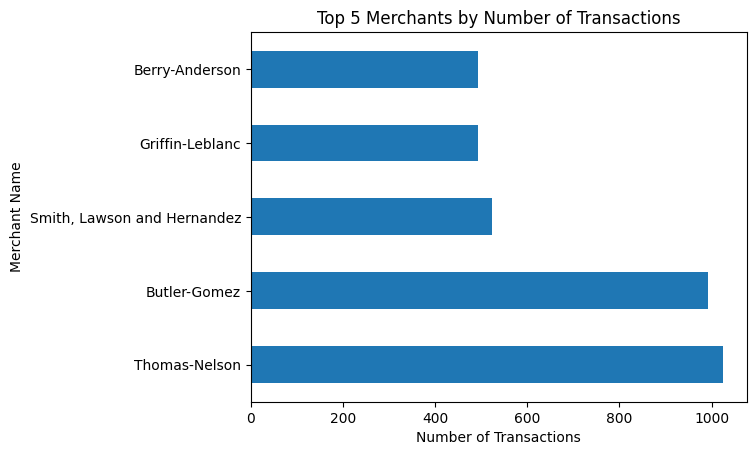

In [14]:
# Q2: Plot the distribution of merchants' transactions as a (horizontal) bar chart
# Restrict yourself to the 5 merchants (we used the top 5)

df_merchants = df_sheets['merchants']
df_branches = df_sheets['branches']

# Merging transactions with branches to get branch_id and merchant_id
merged_transactions_branches = df_transactions.merge(df_branches[['branch_id', 'merchant_id']], on='branch_id')
# Merging the result with merchants to get merchant names
merged_transactions_merchants = merged_transactions_branches.merge(df_merchants[['merchant_id', 'merchant_name']], on='merchant_id')
merchant_transaction_counts = merged_transactions_merchants['merchant_name'].value_counts().nlargest(5)

merchant_transaction_counts.plot(kind='barh')
plt.xlabel('Number of Transactions')
plt.ylabel('Merchant Name')
plt.title('Top 5 Merchants by Number of Transactions')
plt.show()



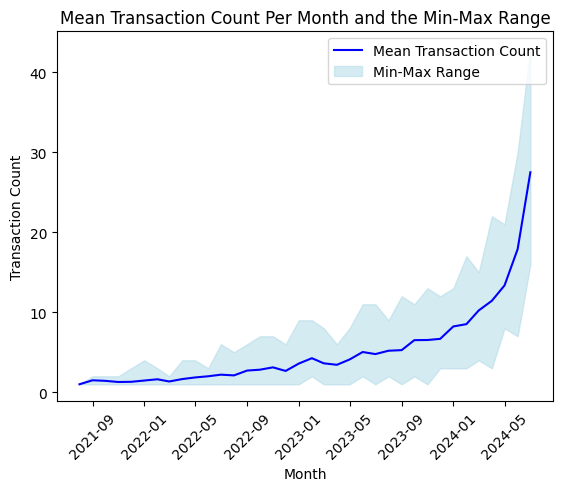

In [15]:
# Q3: Create a line plot of the mean transaction counts in a month, through time. add an area plot on top of the line plot
# depicting the minimum and maximum bounds in each month

df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'])
df_transactions['year_month'] = df_transactions['transaction_date'].dt.to_period('M')
df_transactions['day'] = df_transactions['transaction_date'].dt.to_period('D')

transaction_counts_per_day = df_transactions.groupby(['year_month', 'day']).size().reset_index(name='transaction_count_per_day')

# Grouping by year_month , and calculating mean, min, and max for daily transactions in each month
monthly_stats = transaction_counts_per_day.groupby('year_month').agg(
    mean_transaction_count=('transaction_count_per_day', 'mean'),
    min_transaction_count=('transaction_count_per_day', 'min'),
    max_transaction_count=('transaction_count_per_day', 'max')
).reset_index()


monthly_stats['year_month'] = monthly_stats['year_month'].dt.to_timestamp()

plt.plot(monthly_stats['year_month'], monthly_stats['mean_transaction_count'], label='Mean Transaction Count', color='blue')

# Area plot
plt.fill_between(monthly_stats['year_month'],
                 monthly_stats['min_transaction_count'],
                 monthly_stats['max_transaction_count'],
                 color='lightblue', alpha=0.5, label='Min-Max Range')

plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.title('Mean Transaction Count Per Month and the Min-Max Range')
plt.xticks(rotation=45)
plt.legend()
plt.show()


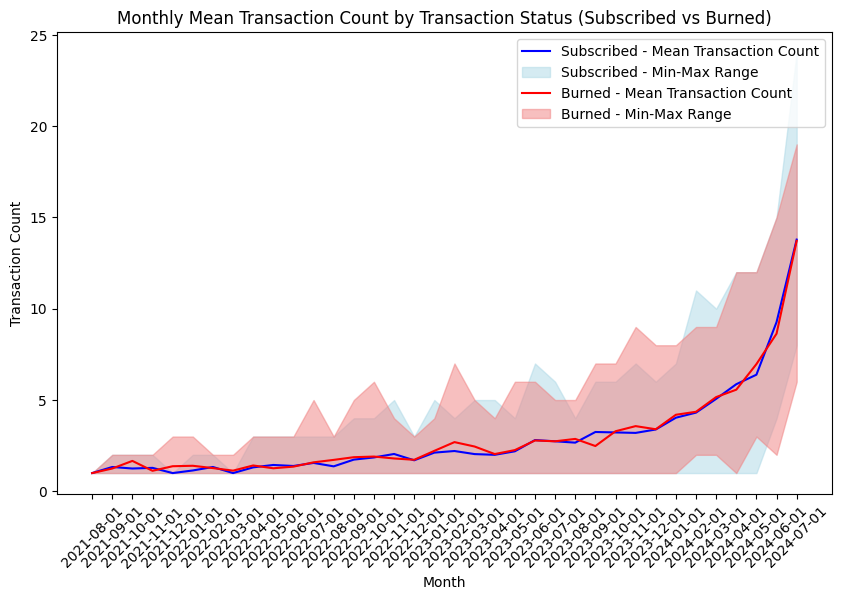

In [16]:
# Q3: Create a line plot of the mean transaction counts in a month, through time. add an area plot on top of the line plot
# depicting the minimum and maximum bounds in each month

df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'])
df_transactions['year_month'] = df_transactions['transaction_date'].dt.to_period('M')
df_transactions['day'] = df_transactions['transaction_date'].dt.to_period('D')

transaction_counts_per_day = df_transactions.groupby(['transaction_status', 'year_month', 'day']).size().reset_index(name='transaction_count_per_day')

# Grouping by year_month , and calculating mean, min, and max for daily transactions in each month
monthly_stats = transaction_counts_per_day.groupby(['transaction_status', 'year_month']).agg(
    mean_transaction_count=('transaction_count_per_day', 'mean'),
    min_transaction_count=('transaction_count_per_day', 'min'),
    max_transaction_count=('transaction_count_per_day', 'max')
).reset_index()


monthly_stats['year_month'] = monthly_stats['year_month'].dt.to_timestamp()
subscribed_data = monthly_stats[monthly_stats['transaction_status'] == 'subscribed']
burned_data = monthly_stats[monthly_stats['transaction_status'] == 'burned']


# subscribed customers
plt.figure(figsize=(10, 6))
plt.plot(subscribed_data['year_month'].astype(str), subscribed_data['mean_transaction_count'], label='Subscribed - Mean Transaction Count', color='blue')
plt.fill_between(subscribed_data['year_month'].astype(str),
                 subscribed_data['min_transaction_count'],
                 subscribed_data['max_transaction_count'],
                 color='lightblue', alpha=0.5, label='Subscribed - Min-Max Range')

# burned customers
plt.plot(burned_data['year_month'].astype(str), burned_data['mean_transaction_count'], label='Burned - Mean Transaction Count', color='red')
plt.fill_between(burned_data['year_month'].astype(str),
                 burned_data['min_transaction_count'],
                 burned_data['max_transaction_count'],
                 color='lightcoral', alpha=0.5, label='Burned - Min-Max Range')

plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.title('Monthly Mean Transaction Count by Transaction Status (Subscribed vs Burned)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**Are there any visible trends in the consuming patterns of subscribed vs. burned customers?**\
The patterns for both subscribed and burned customers appear to follow a similar trajectory. There is no significant divergence between the two groups. This shows that both sets of customers are behaving similarly in terms of transaction frequency. While the ranges for daily transactions differ slightly between the groups at times, the mean transaction counts are quite close throughout most of the period.\
Both subscribed and burned transaction counts, have an upward trend. From around July 2023, the transaction count accelerates for both groups, and it reaches a peak around July 2024. This can indicate increased customer activity, probably caused by seasonal offers, or growing customer engagement. The acceleration that occurs from around July 2023, may have been due to changes in marketing tactics, product launches, or other factors that caused this increase in consumer activity.\
The area for burned customers shows more variability in the min-max range compared to the subscribed customers' area. This suggests that burned customers have more variation in their daily transactions within each month. The larger range for burned customers may imply less consistency in their purchasing behavior.\
Around the end of the period (early 2024), both have very high accelerations, but burned customers show a slightly higher mean transaction count than subscribed customers, although the difference is minimal. This might mean that even customers who are no longer subscribed are still engaging actively with the platform.


**Explain your approach and assumptions once this section is completed.**

**Q1:** The function is_coupon_less, checks if the coupon name ends with a number. We use a regular expression (re.search(r'\d+$', str(coupon_name))) to find a number at the end of the coupon name.
If the number exists and is less than 100, the function returns True, filtering out those coupons. The next step is to merge the filtered transactions with the customer data to get the city_id associated with each customer (via customer_id). We drop duplicates from the city_id to get a list of unique cities. Then we merge this list with the cities dataset to get the actual city_name corresponding to each city_id. Finally, a list of city names is printed.\
**Q2:** We merge df_transactions with df_branches to get the merchant_id (since transactions are made through branches).
Then, the resulting data is merged with the df_merchants to get the merchant_name. After merging, we count the number of transactions (value_counts()) per merchant_name and select the top 5 merchants (nlargest(5)). We plot a horizontal bar chart (barh) using the top 5 merchants' names as the x-axis (merchant names) and the number of transactions on the y-axis.\
**Q3:** We convert the transaction_date column to a datetime format, and create two new columns : year_month: extracts the year and month for each transaction, and day: extracts the day of each transaction. The transactions are grouped by year_month and day to calculate the number of transactions per day (transaction_count_per_day). Then we group the daily transaction counts by year_month to compute the monthly statistics : mean_transaction_count: average transactions per day for each month.
min_transaction_count: minimum daily transaction count within a month.
max_transaction_count: maximum daily transaction count within a month.\
We plot a line plot to represent the mean daily transaction count for each month. Also, we use an area plot (fill_between) to represent the min-max range for daily transactions in each month.\
**Q4:** Transactions are grouped by transaction_status ("subscribed" and "burned") and year_month to compute the mean, minimum, and maximum transaction counts for each status. For each category (subscribed and burned), we plot a separate line plot for mean transaction counts, and an area plot that shows the min-max range for each status.

# 2. Canadian Cheese Directory!

The database of Canadian cheeses made from cow, goat, sheep or buffalo milk has been provided.

In this question you will again perform data wrangling and interpretation.

## 2.1 Loading Phase

Load the csv file into a `DataFrame`

In [17]:
df = pd.read_csv('cheese_data.csv')
df.head()

,Unnamed: 0,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel,FatIndex
0,0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat,0
1,1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat,0
2,2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat,0
3,3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat,0
4,4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat,0


## 2.2 Cleaning Phase

Perform the following actions on the dataset.

1. Describe the type and the value range of each attribute.  
2. Indicate and transform the attributes that are `Categorical`.
3. Are there redundant columns in the dataset (i.e., are there columns whose value depends only on the value of another column)?
4. What are the possible pitfalls of having such columns?

Reduce *data redundancy* by extracting such columns to separate `DataFrames`. Which of the two formats (the initial one or the one with reduced data redundancy) is more susceptible to inconsistencies? At the end print for each `Dataframe` the *type of each column* and it's *shape*.

In [18]:
# Q1

df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            1042 non-null   int64  
 1   CheeseId              1042 non-null   int64  
 2   ManufacturerProvCode  1042 non-null   object 
 3   ManufacturingTypeEn   1042 non-null   object 
 4   MoisturePercent       1028 non-null   float64
 5   FlavourEn             801 non-null    object 
 6   CharacteristicsEn     643 non-null    object 
 7   Organic               1042 non-null   int64  
 8   CategoryTypeEn        1019 non-null   object 
 9   MilkTypeEn            1041 non-null   object 
 10  MilkTreatmentTypeEn   977 non-null    object 
 11  RindTypeEn            721 non-null    object 
 12  CheeseName            1042 non-null   object 
 13  FatLevel              1042 non-null   object 
 14  FatIndex              1042 non-null   int64  
dtypes: float64(1), int64(

,Unnamed: 0,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel,FatIndex
count,1042.000000,1042.000000,1042,1042,1028.000000,801,643,1042.000000,1019,1041,977,721,1042,1042,1042.000000
unique,NaN,NaN,10,3,NaN,635,535,NaN,6,8,3,4,1038,2,NaN
top,NaN,NaN,QC,Industrial,NaN,Mild,Creamy,NaN,Firm Cheese,Cow,Pasteurized,No Rind,Ménestrel (Le),lower fat,NaN
freq,NaN,NaN,796,455,NaN,59,19,NaN,349,743,800,404,2,684,NaN
mean,520.500000,1560.633397,NaN,NaN,47.069747,NaN,NaN,0.095010,NaN,NaN,NaN,NaN,NaN,NaN,0.343570
std,300.943793,451.811164,NaN,NaN,9.592647,NaN,NaN,0.293369,NaN,NaN,NaN,NaN,NaN,NaN,0.475128
min,0.000000,228.000000,NaN,NaN,12.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,260.250000,1280.250000,NaN,NaN,40.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,520.500000,1548.500000,NaN,NaN,46.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,780.750000,1901.750000,NaN,NaN,52.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [19]:
# Q2

# categorical_columns = ['ManufacturerProvCode', 'ManufacturingTypeEn', 'FlavourEn',
                      #  'CharacteristicsEn', 'CategoryTypeEn', 'MilkTypeEn',
                      #  'MilkTreatmentTypeEn', 'RindTypeEn', 'CheeseName', 'FatLevel', 'Organic', 'FatIndex']

# Categorical columns are the ones that are of type object,
# also 'Organic' and 'FatIndex' are categorical columns although their data type is integer
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns += ['Organic', 'FatIndex']

# Converting these columns to categorical data type
df[categorical_columns] = df[categorical_columns].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Unnamed: 0            1042 non-null   int64   
 1   CheeseId              1042 non-null   int64   
 2   ManufacturerProvCode  1042 non-null   category
 3   ManufacturingTypeEn   1042 non-null   category
 4   MoisturePercent       1028 non-null   float64 
 5   FlavourEn             801 non-null    category
 6   CharacteristicsEn     643 non-null    category
 7   Organic               1042 non-null   category
 8   CategoryTypeEn        1019 non-null   category
 9   MilkTypeEn            1041 non-null   category
 10  MilkTreatmentTypeEn   977 non-null    category
 11  RindTypeEn            721 non-null    category
 12  CheeseName            1042 non-null   category
 13  FatLevel              1042 non-null   category
 14  FatIndex              1042 non-null   category
dtypes: c

In [20]:
# Q3

# To check for redundancy, we can look for columns that exhibit high correlation or dependency
numerical_df = df.select_dtypes(include=['number'])
# Correlation matrix for numerical columns
corr_matrix = numerical_df.corr()
print(corr_matrix)

# As we can see, there is a high correlation between Unnamed: 0 and CheeseId. This is because the unnamed column
# is actually a row identifier, which basically does what the cheeseId does. So we don't need it when we already
# have the cheeseId.
# Also, it can be seen from the dataset, that FatIndex and FatLevel have a high correlation. It seems like the index
# is 0 for lower fat, and 1 for higher fat. So it seems like FatIndex is just a binary indicator of whether
# the cheese is lower fat or higher fat. Therefore, it causes redundancy.

                 Unnamed: 0  CheeseId  MoisturePercent
Unnamed: 0         1.000000  0.980996        -0.015327
CheeseId           0.980996  1.000000        -0.009948
MoisturePercent   -0.015327 -0.009948         1.000000


**Q4 : What are the possible pitfalls of having such columns?**
- **Overfitting:** Redundant columns increase the dimensionality of the dataset without providing new information. This can cause a model to overfit to the training data, as it may focus on irrelevant features that do not contribute to generalization but increase the complexity of the model.
- **Multicollinearity:** If two or more features are highly correlated, especially in regression models, it can cause multicollinearity. This makes it hard to determine the individual effect of each feature, as the model struggles to assign proper weights to the correlated features. This can lead to unstable estimates of model coefficients, reducing the interpretability of the model.
- **Increased Computation Cost:** Including unnecessary columns, especially in large datasets, increases the computational cost of training and evaluating the model. Processing time and memory usage can increase significantly when dealing with a higher number of features.
- **Noise Introduction:** Redundant columns may introduce noise in the model, affecting its ability to learn the true underlying patterns. For example, having both FatIndex and FatLevel can confuse the model if they represent the same concept but with slight variations, leading to potential misclassification or regression errors.
- **Bias in Feature Selection:** Some models may prioritize certain redundant features over others due to random initialization or selection algorithms. This can result in misleading feature importance rankings and potentially biased insights.
- **Reduced Model Interpretability:** When similar features are present, understanding which feature contributes most to predictions becomes difficult. This hampers the model’s transparency, especially in decision-making contexts where interpretability is crucial (e.g., in healthcare or finance).
- **Difficulty in Feature Engineering:** In feature engineering or selection, redundant columns make it harder to extract meaningful features or apply proper transformations because it’s unclear whether removing or keeping one over the other will impact the model’s performance.


**Explain your approach and assumptions once this section is completed.**

**Q1:** To understand the dataset, we used df.info() to check the types of each attribute. Then we used df.describe(include='all') to view summary statistics (including value ranges for numeric columns and distribution for categorical columns). Numeric columns have a meaningful range.
Categorical columns are assumed to be encoded as strings or objects.\
**Q2:** We use the select_dtypes function to identify columns in the dataframe (df) that have the data type 'object' (usually strings or categorical data). categorical_columns stores the list of column names that are of type object. Additionally, the columns Organic and FatIndex are included in the list because, although they are stored as integers, they represent categorical information. We change the data type of all identified categorical columns (including Organic and FatIndex) from their current types to the category data type. This is done using the .astype('category') function.\
**Q3:**  We use the .corr() function to compute the correlation matrix of the numerical columns. This matrix shows the pairwise correlation coefficients between all numerical columns. From the correlation matrix, we can observe a very high correlation between Unnamed: 0 and CheeseId. This suggests that Unnamed: 0 is essentially functioning as a row identifier, and is redundant because CheeseId already serves this purpose. Another pair of columns with high correlation is FatIndex and FatLevel. The FatIndex seems to be a binary indicator (0 for low-fat cheese and 1 for high-fat cheese), while FatLevel likely provides more detailed information. Since FatIndex is derived from FatLevel and provides less information, it could be considered redundant.

## 2.3 Querying Phase

Answer the following queries using the functionality of `Pandas`.

* Plot the **proportion** of **ManufacturingTypeEn**, **MoisturePercent**, **CategoryTypeEn**, **MilkTypeEn** columns in four subplots using pie diagrams.

* Categorize the dataframe by the **FatIndex**. Calculate the proportion of each FatIndex in the previous columns (ManufacturingTypeEn, MoisturePercent, CategoryTypeEn, MilkTypeEn) and present your results in a **stacked bar chart**.

* Separate the MoisturePercent values into two intervals that have (approximately) the same number of cheese products in the dataset. Categorize the dataset based on MoistureIndex, FatIndex, ManufacturingTypeEn, MoisturePercent, CategoryTypeEn, MilkTypeEn and calculate the proportions of each category. Represent your results in a separate `DataFrame`.

* Is there any row that is slightly more popular than the others? Do you see any correlation between the cheese attributes and their popularity?


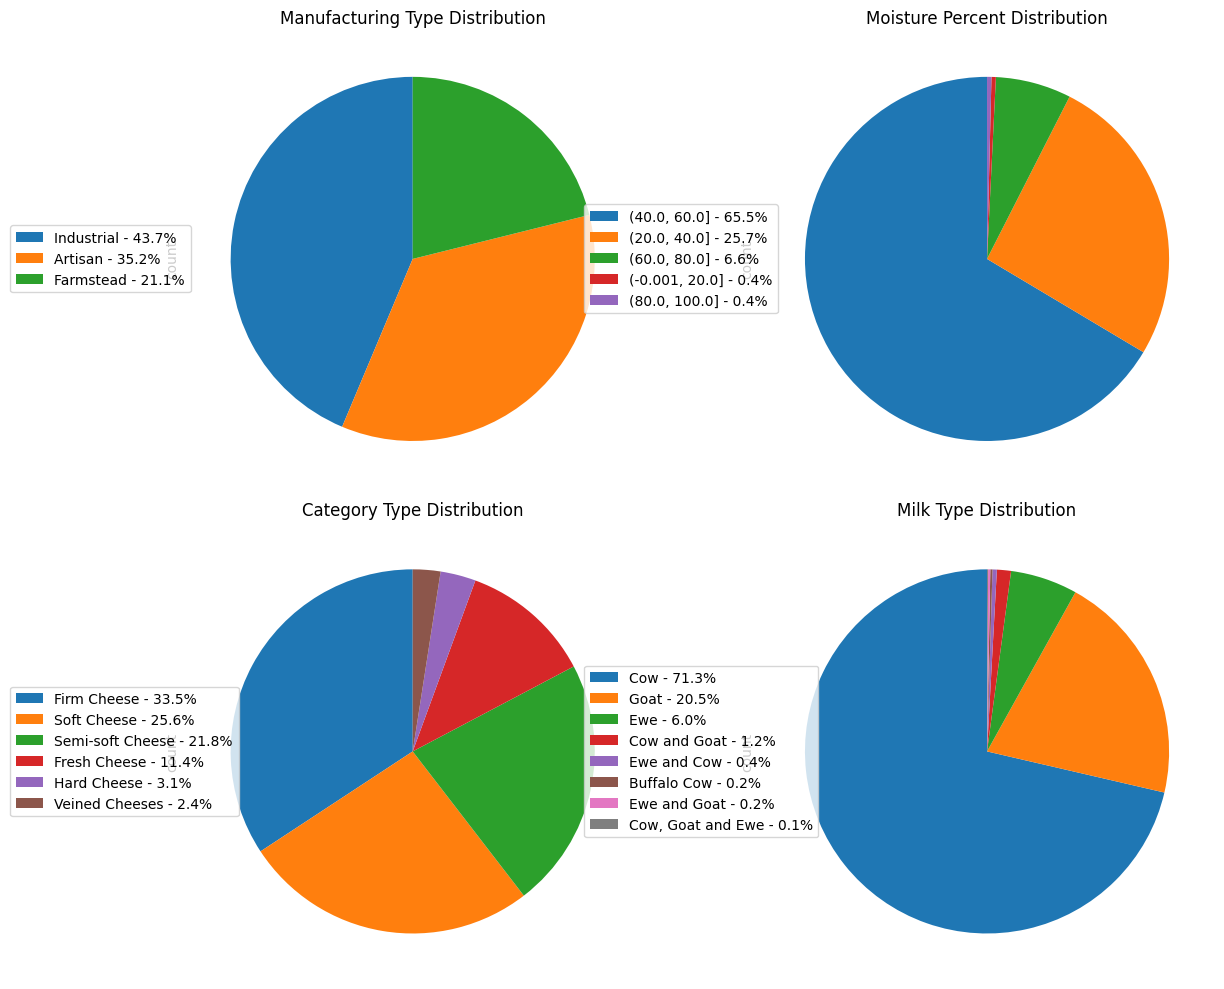

In [21]:
# Q1: Plot the proportion of ManufacturingTypeEn, MoisturePercent, CategoryTypeEn, MilkTypeEn columns
# in four subplots using pie diagrams.

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Pie chart for ManufacturingTypeEn
manufacturing_counts = df['ManufacturingTypeEn'].value_counts()
manufacturing_counts.plot.pie(ax=axs[0, 0], labels=None, startangle=90)
axs[0, 0].set_title('Manufacturing Type Distribution')
manufacturing_labels = [f'{cat} - {count/df.shape[0]*100:.1f}%' for cat, count in zip(manufacturing_counts.index, manufacturing_counts)]
axs[0, 0].legend(manufacturing_labels, bbox_to_anchor=(-0.4, 0.5), loc="center left")

# Pie chart for MoisturePercent (5 bins from 0 to 100)
moisture_bins = [0, 20, 40, 60, 80, 100]  # Explicit bin ranges
moisture_groups = pd.cut(df['MoisturePercent'], bins=moisture_bins, include_lowest=True)
moisture_counts = moisture_groups.value_counts()
moisture_counts.plot.pie(ax=axs[0, 1], labels=None, startangle=90)
axs[0, 1].set_title('Moisture Percent Distribution')
moisture_labels = [f'{cat} - {count/df.shape[0]*100:.1f}%' for cat, count in zip(moisture_counts.index, moisture_counts)]
axs[0, 1].legend(moisture_labels, bbox_to_anchor=(-0.4, 0.5), loc="center left")

# Pie chart for CategoryTypeEn
category_counts = df['CategoryTypeEn'].value_counts()
category_counts.plot.pie(ax=axs[1, 0], labels=None, startangle=90)
axs[1, 0].set_title('Category Type Distribution')
category_labels = [f'{cat} - {count/df.shape[0]*100:.1f}%' for cat, count in zip(category_counts.index, category_counts)]
axs[1, 0].legend(category_labels, bbox_to_anchor=(-0.4, 0.5), loc="center left")

# Pie chart for MilkTypeEn
milk_counts = df['MilkTypeEn'].value_counts()
milk_counts.plot.pie(ax=axs[1, 1], labels=None, startangle=90)
axs[1, 1].set_title('Milk Type Distribution')
milk_labels = [f'{cat} - {count/df.shape[0]*100:.1f}%' for cat, count in zip(milk_counts.index, milk_counts)]
axs[1, 1].legend(milk_labels, bbox_to_anchor=(-0.4, 0.5), loc="center left")

plt.tight_layout()
plt.show()


<ipython-input-22-b74e1bd8fa16>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_col)[target_col].value_counts(normalize=True).unstack().fillna(0)
<ipython-input-22-b74e1bd8fa16>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_col)[target_col].value_counts(normalize=True).unstack().fillna(0)
<ipython-input-22-b74e1bd8fa16>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  r

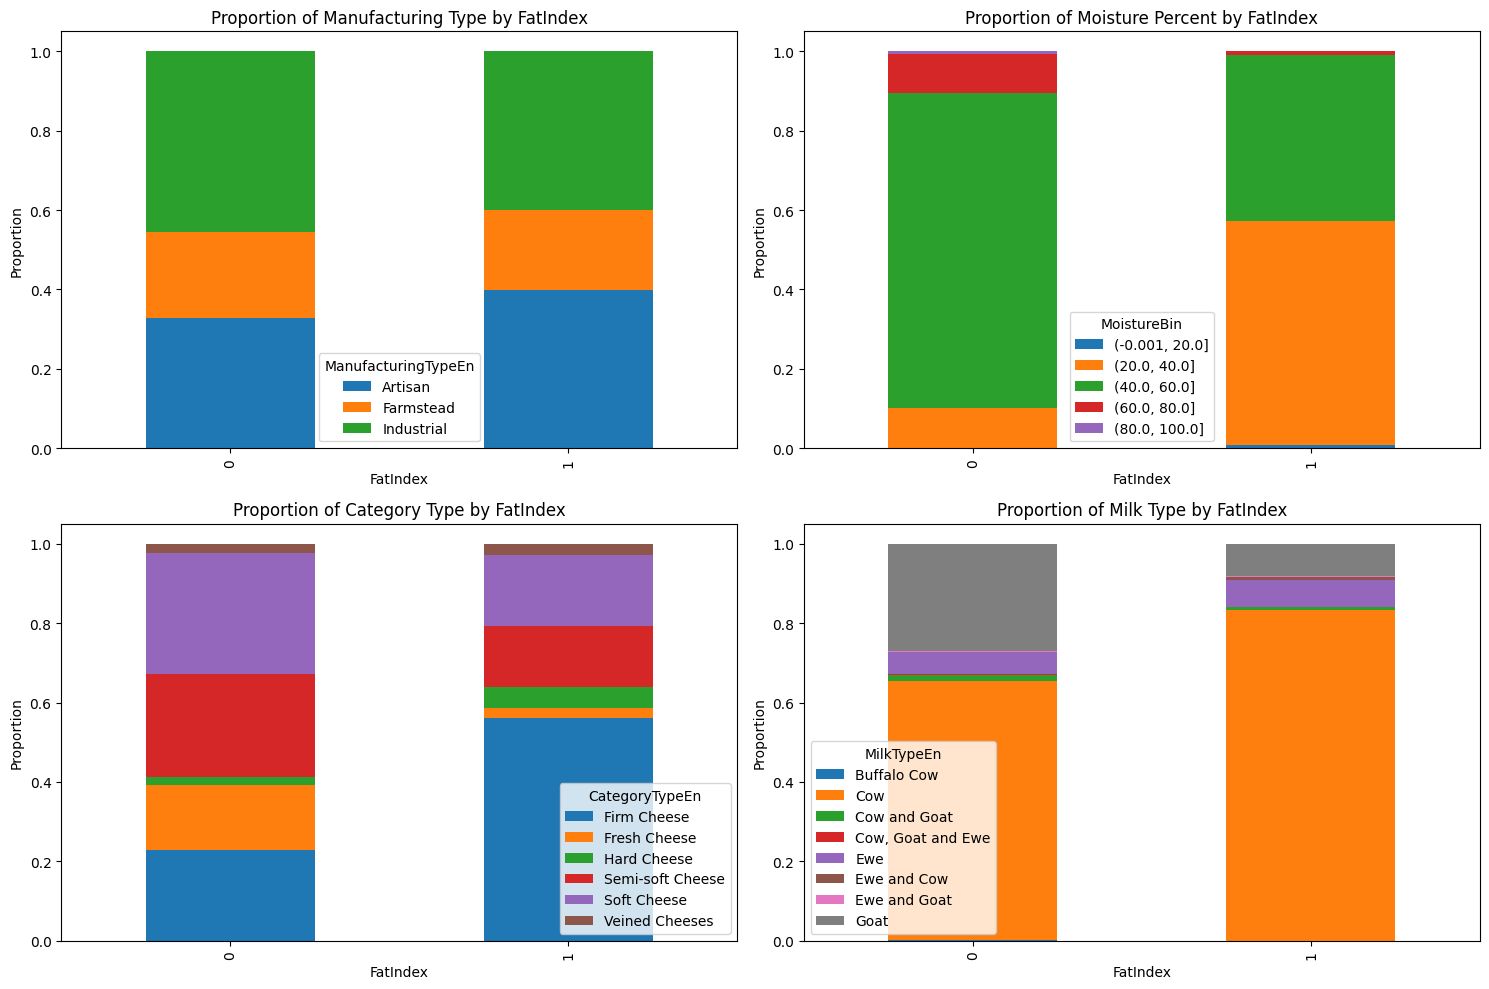

In [22]:
# Q2: Categorize the dataframe by the FatIndex.
# Calculate the proportion of each FatIndex in the previous columns (ManufacturingTypeEn, MoisturePercent, CategoryTypeEn, MilkTypeEn)
# and present your results in a stacked bar chart.

# Function to calculate proportions for categorical columns
def calc_proportion(df, group_col, target_col):
    return df.groupby(group_col)[target_col].value_counts(normalize=True).unstack().fillna(0)

# Calculating proportions for each column grouped by FatIndex
manufacturing_proportion = calc_proportion(df, 'FatIndex', 'ManufacturingTypeEn')
moisture_bins = [0, 20, 40, 60, 80, 100]
df['MoistureBin'] = pd.cut(df['MoisturePercent'], bins=moisture_bins, include_lowest=True)
moisture_proportion = calc_proportion(df, 'FatIndex', 'MoistureBin')
category_proportion = calc_proportion(df, 'FatIndex', 'CategoryTypeEn')
milk_proportion = calc_proportion(df, 'FatIndex', 'MilkTypeEn')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Stacked bar chart for ManufacturingTypeEn
manufacturing_proportion.plot(kind='bar', stacked=True, ax=axs[0, 0])
axs[0, 0].set_title('Proportion of Manufacturing Type by FatIndex')
axs[0, 0].set_ylabel('Proportion')

# Stacked bar chart for MoisturePercent
moisture_proportion.plot(kind='bar', stacked=True, ax=axs[0, 1])
axs[0, 1].set_title('Proportion of Moisture Percent by FatIndex')
axs[0, 1].set_ylabel('Proportion')

# Stacked bar chart for CategoryTypeEn
category_proportion.plot(kind='bar', stacked=True, ax=axs[1, 0])
axs[1, 0].set_title('Proportion of Category Type by FatIndex')
axs[1, 0].set_ylabel('Proportion')

# Stacked bar chart for MilkTypeEn
milk_proportion.plot(kind='bar', stacked=True, ax=axs[1, 1])
axs[1, 1].set_title('Proportion of Milk Type by FatIndex')
axs[1, 1].set_ylabel('Proportion')

plt.tight_layout()
plt.show()


In [23]:
# Q3: Separate the MoisturePercent values into two intervals that have (approximately) the same number of cheese products in the dataset
# Categorize the dataset based on MoistureIndex, FatIndex, ManufacturingTypeEn, MoisturePercent, CategoryTypeEn, MilkTypeEn and
# calculate the proportions of each category. Represent your results in a separate DataFrame.


# Splitting MoisturePercent into two equal-length intervals based on the median
df = pd.read_csv('cheese_data.csv')
median_moisture = df['MoisturePercent'].median()
df['MoistureIndex'] = pd.cut(df['MoisturePercent'], bins=[0, median_moisture, df['MoisturePercent'].max()], labels=['Low Moisture', 'High Moisture'], include_lowest=True)

# Grouping the dataset by the specified columns
proportion_df = df.groupby(['MoistureIndex', 'FatIndex', 'ManufacturingTypeEn', 'CategoryTypeEn', 'MilkTypeEn']).size().reset_index(name='Count')

proportion_df['Proportion'] = proportion_df['Count'] / proportion_df['Count'].sum()
proportion_df


<ipython-input-23-79bd123b2944>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportion_df = df.groupby(['MoistureIndex', 'FatIndex', 'ManufacturingTypeEn', 'CategoryTypeEn', 'MilkTypeEn']).size().reset_index(name='Count')


,MoistureIndex,FatIndex,ManufacturingTypeEn,CategoryTypeEn,MilkTypeEn,Count,Proportion
0,Low Moisture,0,Artisan,Firm Cheese,Buffalo Cow,0,0.000000
1,Low Moisture,0,Artisan,Firm Cheese,Cow,22,0.021891
2,Low Moisture,0,Artisan,Firm Cheese,Cow and Goat,1,0.000995
3,Low Moisture,0,Artisan,Firm Cheese,"Cow, Goat and Ewe",0,0.000000
4,Low Moisture,0,Artisan,Firm Cheese,Ewe,1,0.000995
...,...,...,...,...,...,...,...
571,High Moisture,1,Industrial,Veined Cheeses,"Cow, Goat and Ewe",0,0.000000
572,High Moisture,1,Industrial,Veined Cheeses,Ewe,0,0.000000
573,High Moisture,1,Industrial,Veined Cheeses,Ewe and Cow,0,0.000000
574,High Moisture,1,Industrial,Veined Cheeses,Ewe and Goat,0,0.000000


In [24]:
# Q4: Is there any row that is slightly more popular than the others?
# Do you see any correlation between the cheese attributes and their popularity?

# Sorting the DataFrame by Proportion to find the most popular row
most_popular_rows = proportion_df.sort_values(by='Proportion', ascending=False)
most_popular_rows.head()


,MoistureIndex,FatIndex,ManufacturingTypeEn,CategoryTypeEn,MilkTypeEn,Count,Proportion
145,Low Moisture,1,Artisan,Firm Cheese,Cow,77,0.076617
241,Low Moisture,1,Industrial,Firm Cheese,Cow,70,0.069652
417,High Moisture,0,Industrial,Soft Cheese,Cow,69,0.068657
97,Low Moisture,0,Industrial,Firm Cheese,Cow,60,0.059701
321,High Moisture,0,Artisan,Soft Cheese,Cow,39,0.038806


In [25]:
# Top 10 rows

most_popular_rows.head(10)

,MoistureIndex,FatIndex,ManufacturingTypeEn,CategoryTypeEn,MilkTypeEn,Count,Proportion
145,Low Moisture,1,Artisan,Firm Cheese,Cow,77,0.076617
241,Low Moisture,1,Industrial,Firm Cheese,Cow,70,0.069652
417,High Moisture,0,Industrial,Soft Cheese,Cow,69,0.068657
97,Low Moisture,0,Industrial,Firm Cheese,Cow,60,0.059701
321,High Moisture,0,Artisan,Soft Cheese,Cow,39,0.038806
409,High Moisture,0,Industrial,Semi-soft Cheese,Cow,39,0.038806
561,High Moisture,1,Industrial,Soft Cheese,Cow,34,0.033831
193,Low Moisture,1,Farmstead,Firm Cheese,Cow,29,0.028856
313,High Moisture,0,Artisan,Semi-soft Cheese,Cow,28,0.027861
375,High Moisture,0,Farmstead,Soft Cheese,Goat,24,0.023881


**Is there any row that is slightly more popular than the others?**\
Yes, the row with the combination of attributes:\
MoistureIndex: Low Moisture\
FatIndex: 1\
ManufacturingTypeEn: Artisan\
CategoryTypeEn: Firm Cheese\
MilkTypeEn: Cow\
has the highest count with 77 products, representing about 7.66% of the dataset. This row is slightly more popular than the next most popular rows, which are:

Low Moisture, FatIndex 1, Industrial, Firm Cheese, Cow with 70 products (6.97%)\
High Moisture, FatIndex 0, Industrial, Soft Cheese, Cow with 69 products (6.87%)\
While the most popular row stands out slightly, there isn't an overwhelming difference between the top rows, indicating a relatively balanced distribution among the top combinations. From the 4th top to the 5th top, we see a noticeable decrease in the counts, which means the 4 top ones have noticeably higher counts.

**Do you see any correlation between the cheese attributes and their popularity?**
- **MoistureIndex:**
Both Low Moisture and High Moisture cheeses are represented in the top 10, but Low Moisture cheeses are slightly more popular, particularly when combined with other attributes like Firm Cheese and Cow milk.
- **FatIndex**:
There is a mixture of cheeses with FatIndex 0 (lower fat) and FatIndex 1 (higher fat) in the top 10. However, FatIndex 1 cheeses (higher fat) tend to rank higher in the list, which suggests a preference for higher fat cheeses.
- **ManufacturingTypeEn:**
Industrial cheeses are more frequent in the top 10, with both Industrial and Artisan types appearing multiple times. However, the most popular cheese is Artisan.
- **CategoryTypeEn:**
Firm Cheese is very popular, making up a large portion of the top 5 rows. Soft Cheese and Semi-soft Cheese are also well-represented but generally rank lower than Firm Cheese.
- **MilkTypeEn:**
Cow's milk dominates the top 10, suggesting that cow's milk cheese is much more popular than cheeses made from other types of milk. Only one row in the top 10 includes Goat's milk, showing that non-cow milk cheeses are less common or less popular in this dataset.
- So overally, we can say that cow cheese definitely has a strong correlation with popularity. But for other attributes, the correlation is not that strong.

**Explain your approach and assumptions once this section is completed.**

**Q1:** We use value_counts() to count the occurrences of each value in the ManufacturingTypeEn column.
The pie chart is plotted using plot.pie(), and a legend is added showing the proportion of each category as a percentage of the total dataset. pd.cut() bins the MoisturePercent into 5 ranges: [0-20], [20-40], [40-60], [60-80], and [80-100].
value_counts() is used to count the number of cheeses in each moisture bin.
We plot pie chart for moisture bins, with a corresponding legend. Similarly, pie charts are created for the CategoryTypeEn and MilkTypeEn columns using the same approach as above. The four pie charts provide a visual distribution of how cheeses are classified across these four attributes.\
**Q2:** The function calc_proportion() groups the data by FatIndex and calculates the proportion of each unique value in the target column (e.g., ManufacturingTypeEn). The results are pivoted into a DataFrame using unstack(). We calculate he proportions for the columns: ManufacturingTypeEn, MoisturePercent (grouped into bins), CategoryTypeEn, and MilkTypeEn. The function pd.cut() is used to bin MoisturePercent as in Q1. Each proportion is plotted as a stacked bar chart, with one subplot for each of the four columns.
The y-axis represents the proportion of each category for different values of FatIndex.\
**Q3:** We devide the dataset into two moisture categories (Low Moisture and High Moisture) using the median of the MoisturePercent values as the threshold. pd.cut() assigns these two categories. We group the dataset by multiple columns: MoistureIndex, FatIndex, ManufacturingTypeEn, CategoryTypeEn, and MilkTypeEn.
For each group, the count of rows (the number of cheeses that fall into that group) is computed. The proportion of each group is calculated by dividing the group count by the total number of cheeses in the dataset. The results are presented in a new DataFrame (proportion_df), which contains the cheese counts and their respective proportions for each group.\
**Q4:** We sort the DataFrame created in Q3 (proportion_df) in descending order based on the Proportion column.
The top rows are displayed to identify the most popular combinations of cheese attributes.




# 3. Business Analyst Job Listings  

## 3.1 Loading Phase

As we will learn further in the course, a considerable source of data is free internet information which is crawled!

4092 business analyst job listings scraped from glassdoor are provided at `data/Q3`. Load the data in a `DataFrame`

In [26]:
df = pd.read_csv('BusinessAnalyst.csv')
df.head()

,Unnamed: 0,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,0,Business Analyst - Clinical & Logistics Platform,$56K-$102K (Glassdoor est.),Company Overview\n\n\nAt Memorial Sloan Ketter...,3.9,Memorial Sloan-Kettering\n3.9,"New York, NY","New York, NY",10000+ employees,1884,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),"Mayo Clinic, The Johns Hopkins Hospital, MD An...",-1
1,1,1,Business Analyst,$56K-$102K (Glassdoor est.),We are seeking for an energetic and collaborat...,3.8,Paine Schwartz Partners\n3.8,"New York, NY","New York, NY",1 to 50 employees,-1,Company - Private,Venture Capital & Private Equity,Finance,Unknown / Non-Applicable,-1,True
2,2,2,Data Analyst,$56K-$102K (Glassdoor est.),"For more than a decade, Asembia has been worki...",3.6,Asembia\n3.6,"Florham Park, NJ","Florham Park, NJ",501 to 1000 employees,2004,Company - Private,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$5 to $10 million (USD),-1,-1
3,3,3,"Information Security Analyst, Incident Response",$56K-$102K (Glassdoor est.),Job Description Summary\nThe Information Secur...,3.6,BD\n3.6,"Franklin Lakes, NJ","Franklin Lakes, NJ",10000+ employees,1897,Company - Public,Health Care Products Manufacturing,Manufacturing,$10+ billion (USD),"Abbott, Siemens, Baxter",-1
4,4,4,Analyst - FP&A Global Revenue,$56K-$102K (Glassdoor est.),Magnite is the world's largest independent sel...,3.4,Rubicon Project\n3.4,"New York, NY","Los Angeles, CA",201 to 500 employees,2007,Company - Public,Internet,Information Technology,$100 to $500 million (USD),"PubMatic, AppNexus, Index Exchange",True


## 3.2 Cleaning Phase

Perform the following actions on the dataset.

1. Describe the type and the value range of each attribute.  
2. Indicate and transform the attributes that are `Categorical`.
3. Replace **Salary Estimate** column with expected salary.
4. Explore lower and upper bounds of **Ratings** column. Fix any inconsitensies.
5. Provide a numerical column for expected company size.

In [27]:
# Q1: Describe the type and the value range of each attribute

print(df.dtypes)
df.describe()

Unnamed: 0           object
index                object
Job Title            object
Salary Estimate      object
Job Description      object
Rating               object
Company Name         object
Location             object
Headquarters         object
Size                 object
Founded              object
Type of ownership    object
Industry             object
Sector               object
Revenue              object
Competitors          object
Easy Apply           object
dtype: object


,Unnamed: 0,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
count,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,4092,3692,3692
unique,3962,3706,2210,167,3732,41,2197,218,625,17,212,33,110,63,15,472,2
top,Business Analyst,$35K-$65K (Glassdoor est.),Business Analyst,$43K-$78K (Glassdoor est.),Citi\n3.7,"Jacksonville, FL","Staffigo Technical Services, LLC\n5.0","San Diego, CA",-1,10000+ employees,-1,Company - Private,IT Services,Information Technology,Unknown / Non-Applicable,-1,-1
freq,16,30,502,60,22,392,156,348,316,717,1006,2081,620,1060,864,2676,3559


In [28]:
# Q1:
# As all of the columns are of type object (string in pandas), we need to
# convert the numeric ones to numeric, so that we can see the range

df['Rating Numeric'] = pd.to_numeric(df['Rating'], errors='coerce')

df['Salary Min Numeric'] = df['Salary Estimate'].str.extract(r'(\d+)K').astype(float) * 1000
df['Salary Max Numeric'] = df['Salary Estimate'].str.extract(r'-\$(\d+)K').astype(float) * 1000

df['Founded Numeric'] = pd.to_numeric(df['Founded'], errors='coerce')

def size_to_numeric(size_str):
    limits = re.findall(r'\d+', size_str)
    if limits:
        # If the string contains two numbers (e.g., "1 to 50"), return the upper bound
        return int(limits[-1])
    elif '10000+' in size_str:  # Handle cases like "10000+ employees"
        return 15000  # Assuming we treat "10000+" as an estimate of 15000
    else:
        return None

df['Size Numeric'] = df['Size'].apply(size_to_numeric)
df['Size Numeric'] = pd.to_numeric(df['Size Numeric'], errors='coerce')

df['index Numeric'] = pd.to_numeric(df['index'], errors='coerce')

def parse_revenue(revenue_str):
    if pd.isnull(revenue_str) or "Unknown" in revenue_str:
        return np.nan

    billion_multiplier = 1e9
    million_multiplier = 1e6

    if 'billion' in revenue_str:
        multiplier = billion_multiplier
    elif 'million' in revenue_str:
        multiplier = million_multiplier
    else:
        return np.nan

    match = re.search(r'\$(\d+\.?\d*)\s*(?:to\s*\$(\d+\.?\d*))?', revenue_str)

    if match:
        low_value = float(match.group(1))
        high_value = match.group(2)

        if high_value:  # If there's a range ($X to $Y)
            high_value = float(high_value)
            return (low_value + high_value) / 2 * multiplier  # Return the average and multiply by the correct scale

        else:  # If there's an upper bound ($X+)
            return low_value * multiplier  # Return the lower bound multiplied by the correct scale

    return np.nan  # If no valid match is found

df['Revenue Numeric'] = df['Revenue'].apply(parse_revenue)

columns = ['index Numeric', 'Salary Min Numeric', 'Salary Max Numeric', 'Rating Numeric', 'Size Numeric', 'Revenue Numeric', 'Founded Numeric']

min_values = df[columns].min()
max_values = df[columns].max()

print("Minimum values:")
print(min_values)

print("\nMaximum values:")
print(max_values)


Minimum values:
index Numeric               0.0
Salary Min Numeric      27000.0
Salary Max Numeric      48000.0
Rating Numeric             -1.0
Size Numeric                1.0
Revenue Numeric       1000000.0
Founded Numeric            -1.0
dtype: float64

Maximum values:
index Numeric         4.399000e+03
Salary Min Numeric    1.240000e+05
Salary Max Numeric    2.260000e+05
Rating Numeric        5.000000e+00
Size Numeric          1.000000e+04
Revenue Numeric       5.000000e+11
Founded Numeric       2.020000e+03
dtype: float64


In [29]:
# Q2: Indicate and transform the attributes that are Categorical

categorical_columns = ['Job Title', 'Company Name', 'Location', 'Headquarters', 'Type of ownership',
                       'Industry', 'Sector', 'Competitors', 'Easy Apply']

df[categorical_columns] = df[categorical_columns].astype('category')
print(df.dtypes)

Unnamed: 0              object
index                   object
Job Title             category
Salary Estimate         object
Job Description         object
Rating                  object
Company Name          category
Location              category
Headquarters          category
Size                    object
Founded                 object
Type of ownership     category
Industry              category
Sector                category
Revenue                 object
Competitors           category
Easy Apply            category
Rating Numeric         float64
Salary Min Numeric     float64
Salary Max Numeric     float64
Founded Numeric        float64
Size Numeric           float64
index Numeric          float64
Revenue Numeric        float64
dtype: object


In [30]:
# Q3: Replace Salary Estimate column with expected salary.

def get_expected_salary(salary_string):
    salary_string = salary_string.replace('(Glassdoor est.)', '')
    salary_range = re.findall(r'\d+', salary_string)
    if len(salary_range) == 2:
        lower_bound = int(salary_range[0]) * 1000
        upper_bound = int(salary_range[1]) * 1000
        expected_salary = (lower_bound + upper_bound) / 2
    else:
        expected_salary = None

    return expected_salary


df['Expected Salary'] = df['Salary Estimate'].apply(get_expected_salary)
df.drop('Salary Estimate', axis=1, inplace=True)
df


,Unnamed: 0,index,Job Title,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,Competitors,Easy Apply,Rating Numeric,Salary Min Numeric,Salary Max Numeric,Founded Numeric,Size Numeric,index Numeric,Revenue Numeric,Expected Salary
0,0,0,Business Analyst - Clinical & Logistics Platform,Company Overview\n\n\nAt Memorial Sloan Ketter...,3.9,Memorial Sloan-Kettering\n3.9,"New York, NY","New York, NY",10000+ employees,1884,...,"Mayo Clinic, The Johns Hopkins Hospital, MD An...",-1,3.9,56000.0,102000.0,1884.0,10000.0,0.0,3.500000e+09,79000.0
1,1,1,Business Analyst,We are seeking for an energetic and collaborat...,3.8,Paine Schwartz Partners\n3.8,"New York, NY","New York, NY",1 to 50 employees,-1,...,-1,True,3.8,56000.0,102000.0,-1.0,50.0,1.0,NaN,79000.0
2,2,2,Data Analyst,"For more than a decade, Asembia has been worki...",3.6,Asembia\n3.6,"Florham Park, NJ","Florham Park, NJ",501 to 1000 employees,2004,...,-1,-1,3.6,56000.0,102000.0,2004.0,1000.0,2.0,7.500000e+06,79000.0
3,3,3,"Information Security Analyst, Incident Response",Job Description Summary\nThe Information Secur...,3.6,BD\n3.6,"Franklin Lakes, NJ","Franklin Lakes, NJ",10000+ employees,1897,...,"Abbott, Siemens, Baxter",-1,3.6,56000.0,102000.0,1897.0,10000.0,3.0,1.000000e+10,79000.0
4,4,4,Analyst - FP&A Global Revenue,Magnite is the world's largest independent sel...,3.4,Rubicon Project\n3.4,"New York, NY","Los Angeles, CA",201 to 500 employees,2007,...,"PubMatic, AppNexus, Index Exchange",True,3.4,56000.0,102000.0,2007.0,500.0,4.0,3.000000e+08,79000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4087,Help Desk Analyst,$66K-$114K (Glassdoor est.),Ref ID: 01120-0011488945Classification: Help D...,Robert Half\n3.5,"Jacksonville, FL","Menlo Park, CA",10000+ employees,1948,Company - Public,Staffing & Outsourcing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000.0
4088,System Analyst (Data) - PL/SQl Server,$66K-$114K (Glassdoor est.),Job Title: System Analyst (Data) - PL/SQl Serv...,Diverse Lynx\n3.9,"Jacksonville, FL","Princeton, NJ",501 to 1000 employees,2002,Company - Private,IT Services,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000.0
4089,Programmer Analyst- PeopleSoft ( Finance and S...,$66K-$114K (Glassdoor est.),Job Opening Summary\nReports to the Systems Ap...,Shands at the University of Florida\n4.0,"Jacksonville, FL","Gainesville, FL",10000+ employees,-1,Subsidiary or Business Segment,Health Care Services & Hospitals,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0
4090,Loss Mitigation Analyst,$66K-$114K (Glassdoor est.),Job Description\nA knowledgeable job-seeker is...,Contemporary Staffing Solutions\n4.4,"Jacksonville, FL","Mount Laurel, NJ",1001 to 5000 employees,1994,Company - Private,Staffing & Outsourcing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000.0


In [31]:
# Q4: Explore lower and upper bounds of Ratings column. Fix any inconsitensies

min_rating = df['Rating'].min()
max_rating = df['Rating'].max()

print(f"Ratings Range : [{min_rating} to {max_rating}]")

Ratings Range : [-1.0 to Ponte Vedra Beach, FL]


In [32]:
# Q4 :
# As we can see there are 2 inconsistencies:
# 1. Numbers out of [0, 5] : We remove these rows.
# 2. Strings instead of numerical values : It seems like the rating attribute for
# these tuples, are in the wrong column (the ratings are in salary estimate column)
# So we try to replace the columns


# Identifying rows where 'Rating' contains strings (possible salary values in 'Rating')
# Convert non-numeric strings to NaN in the 'Rating' column
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Checking if values are in the wrong columns
wrong_columns = df[df['Rating'].isna() & df['Expected Salary'].apply(lambda x: isinstance(x, str))]

# Replacing the columns (swapping 'Rating' and 'Expected Salary' for affected rows)
for idx in wrong_columns.index:
    df.at[idx, 'Rating'] = df.at[idx, 'Expected Salary']  # Moving salary value to Rating
    df.at[idx, 'Expected Salary'] = np.nan  # Clearing the incorrect entry in the salary column

# Removing rows with ratings out of the valid range [0, 5]
df = df[(df['Rating'] >= 0) & (df['Rating'] <= 5)]

min_rating = df['Rating'].min()
max_rating = df['Rating'].max()

print(f"Corrected Ratings Range: [{min_rating} to {max_rating}]")


Corrected Ratings Range: [1.0 to 5.0]


In [34]:
# Q5: Provide a numerical column for expected company size

# Based on number of employees
def company_size_to_numeric(size_str):
    limits = re.findall(r'\d+', size_str)
    if limits:
        # If the string contains two numbers (e.g., "1 to 50"), return the upper bound
        return int(limits[-1])
    elif '10000+' in size_str:  # Handle cases like "10000+ employees"
        return 15000  # Assuming we treat "10000+" as an estimate of 15000
    else:
        return None

df['Expected Company Size'] = df['Size'].apply(company_size_to_numeric)
df

<ipython-input-34-a1839f885114>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Expected Company Size'] = df['Size'].apply(company_size_to_numeric)


,Unnamed: 0,index,Job Title,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,Easy Apply,Rating Numeric,Salary Min Numeric,Salary Max Numeric,Founded Numeric,Size Numeric,index Numeric,Revenue Numeric,Expected Salary,Expected Company Size
0,0,0,Business Analyst - Clinical & Logistics Platform,Company Overview\n\n\nAt Memorial Sloan Ketter...,3.9,Memorial Sloan-Kettering\n3.9,"New York, NY","New York, NY",10000+ employees,1884,...,-1,3.9,56000.0,102000.0,1884.0,10000.0,0.0,3.500000e+09,79000.0,10000.0
1,1,1,Business Analyst,We are seeking for an energetic and collaborat...,3.8,Paine Schwartz Partners\n3.8,"New York, NY","New York, NY",1 to 50 employees,-1,...,True,3.8,56000.0,102000.0,-1.0,50.0,1.0,NaN,79000.0,50.0
2,2,2,Data Analyst,"For more than a decade, Asembia has been worki...",3.6,Asembia\n3.6,"Florham Park, NJ","Florham Park, NJ",501 to 1000 employees,2004,...,-1,3.6,56000.0,102000.0,2004.0,1000.0,2.0,7.500000e+06,79000.0,1000.0
3,3,3,"Information Security Analyst, Incident Response",Job Description Summary\nThe Information Secur...,3.6,BD\n3.6,"Franklin Lakes, NJ","Franklin Lakes, NJ",10000+ employees,1897,...,-1,3.6,56000.0,102000.0,1897.0,10000.0,3.0,1.000000e+10,79000.0,10000.0
4,4,4,Analyst - FP&A Global Revenue,Magnite is the world's largest independent sel...,3.4,Rubicon Project\n3.4,"New York, NY","Los Angeles, CA",201 to 500 employees,2007,...,True,3.4,56000.0,102000.0,2007.0,500.0,4.0,3.000000e+08,79000.0,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3686,3686,4394,Urgent - Business Analyst (Information Technol...,Job Description\nAbout us:\n\nStaffigo is in t...,5.0,"Staffigo Technical Services, LLC\n5.0","Austin, TX","Woodridge, IL",51 to 200 employees,2008,...,-1,5.0,58000.0,103000.0,2008.0,200.0,4394.0,7.500000e+07,80500.0,200.0
3687,3687,4395,Pega Business Analyst,• 5 yrs relevant experience in:- Experience wi...,3.1,Tista Science and Technology Corporation\n3.1,"Austin, TX","Rockville, MD",501 to 1000 employees,2005,...,-1,3.1,58000.0,103000.0,2005.0,1000.0,4395.0,7.500000e+06,80500.0,1000.0
3688,3688,4396,Jr.Business Analyst,Job Description\n\nNew businesses are making t...,5.0,"Staffigo Technical Services, LLC\n5.0","Austin, TX","Woodridge, IL",51 to 200 employees,2008,...,-1,5.0,58000.0,103000.0,2008.0,200.0,4396.0,7.500000e+07,80500.0,200.0
3690,3690,4398,"AVP, Business System",We are looking for a AVP Business System Analy...,3.5,LPL Financial\n3.5,"Austin, TX","Boston, MA",1001 to 5000 employees,1968,...,-1,3.5,58000.0,103000.0,1968.0,5000.0,4398.0,3.500000e+09,80500.0,5000.0


**Explain your approach and assumptions once this section is completed.**

**Q1:** We started by inspecting the data types using df.dtypes and generating a statistical summary with df.describe().
Since many columns were of type object, we manually converted numeric-like columns to numeric types for proper analysis.
Salary Estimate: Extracted the minimum and maximum salary values from the text, converting them into numeric ranges.
Founded: Converted the Founded year to numeric values.
Size: Converted employee size ranges (e.g., "1 to 50 employees") to numeric, extracting the upper bound and handling cases like "10000+" employees with a custom estimate (15,000).
Revenue: Used regex to parse revenue ranges in millions or billions and calculate the mid-point or estimate the lower bound.
We calculated and displayed the min/max values for these numeric columns, providing insights into the value ranges of attributes such as salary, company size, revenue, and rating.\
**Q2:** We identified columns with categorical data, such as job title, company name, location, etc.
Converted these columns from object type to category, optimizing memory usage and clarifying their intended purpose as categorical variables.\
**Q3:** We created a function get_expected_salary to extract salary ranges from the Salary Estimate column and calculate the average salary (expected salary).
We used regex to extract the numeric portion of the salary and calculated the average of the lower and upper salary bounds.
At the end, we replaced the Salary Estimate column with this new Expected Salary column and dropped the original column to avoid redundancy.\
**Q4:** We first identified the range of ratings, checking for inconsistencies.
Issue 1: Ratings that were out of the valid range of [0, 5].
Issue 2: Some ratings were strings instead of numeric values, indicating possible data misplacement.
Fixed misplacements by checking rows where ratings were NaN but the salary was stored as a string, and swapped these values if necessary.
We removed rows where ratings fell outside the [0, 5] range to ensure consistency.
After cleaning, we recalculated the corrected range of ratings.\
**Q5:** We extended the logic from Q1 to handle company size, using a function to extract and convert company size information into a numeric value based on the upper bound of the range (e.g., for "1 to 50 employees", 50 was used).
In cases where size exceeded 10,000 employees, we assigned an estimated value (15,000).
We created a new column Expected Company Size that represents this transformation in numeric form.

## 3.3 Querying Phase

Answer the following queries using the functionality of `Pandas`.

1. Provide a pie chart of the job titles. What are the most two popular positions?
2. Consider three variables in one's interest in a job position : Salary, Size of the company and the city. Create 3 scatter plots of peoples' ratings vs. these three variables.
3. Is there any linear correlation evident in either of the plots? Configure your answers using `Scipy.stats`
4. Justify the following claim : "Higher salary causes more satisfaction towards the job".
5. Extract each and every word out of Job Description. Append all of the words and filter them in order to keep the adjectives (Hint: You may perform this filtering using the English adjective corpus provided at `data/Q3`).
6. Create a wordcloud image out of the filtered words (`pip install wordcloud`). What are the main capabilities one must posses in order to hold an Analyst position in the US?

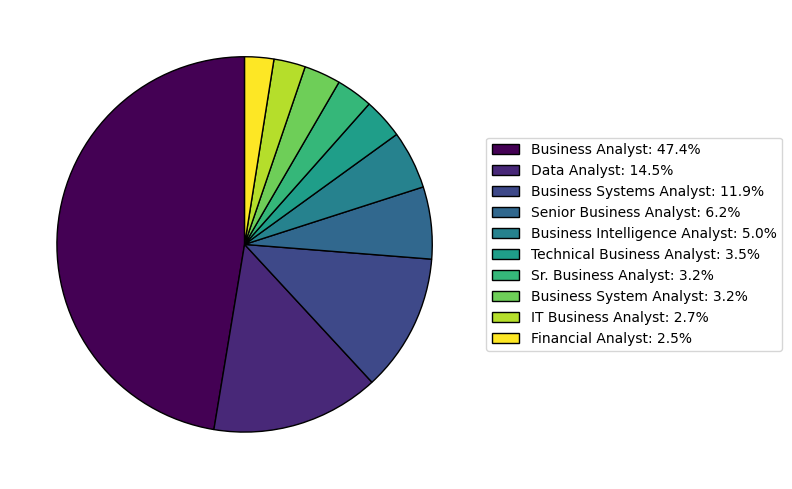

Two most popular positions among the top 10:
Job Title
Business Analyst    435
Data Analyst        133
Name: count, dtype: int64


In [35]:
# Q1: Provide a pie chart of the job titles. What are the most two popular positions?

# Counting the occurrences of each job title
job_title_counts = df['Job Title'].value_counts()
top_10_job_titles = job_title_counts.head(10)


plt.figure(figsize=(8, 8))
pie_chart = top_10_job_titles.plot.pie(startangle=90, cmap='viridis', wedgeprops={'edgecolor': 'black'}, labels=None)

plt.title('')
plt.ylabel('')

percentages = top_10_job_titles / top_10_job_titles.sum() * 100
plt.legend([f"{title}: {percent:.1f}%" for title, percent in zip(top_10_job_titles.index, percentages)], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Identifying the two most popular positions from the top 10
most_popular = top_10_job_titles.head(2)
print("Two most popular positions among the top 10:")
print(most_popular)



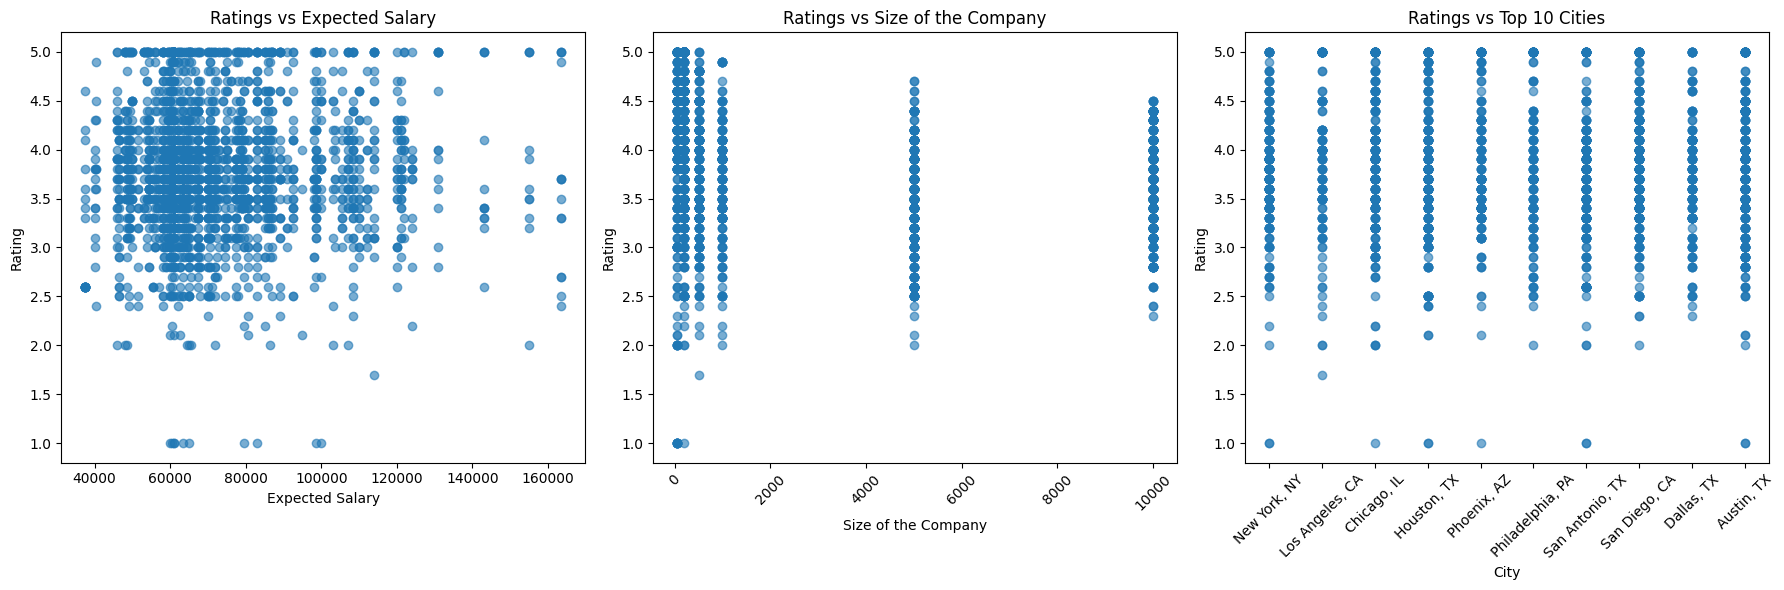

In [36]:
# Q2: Consider three variables in one's interest in a job position : Salary, Size of the company and the city.
# Create 3 scatter plots of peoples' ratings vs. these three variables.

top_cities = df['Location'].value_counts().head(10).index
filtered_df = df[df['Location'].isin(top_cities)]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for Ratings vs Expected Salary
axs[0].scatter(filtered_df['Expected Salary'], filtered_df['Rating'], alpha=0.6)
axs[0].set_title('Ratings vs Expected Salary')
axs[0].set_xlabel('Expected Salary')
axs[0].set_ylabel('Rating')

# Scatter plot for Ratings vs Size of the Company
axs[1].scatter(filtered_df['Size Numeric'], filtered_df['Rating'], alpha=0.6)
axs[1].set_title('Ratings vs Size of the Company')
axs[1].set_xlabel('Size of the Company')
axs[1].set_ylabel('Rating')
axs[1].tick_params(axis='x', rotation=45)

# Scatter plot for Ratings vs Top 10 Cities
axs[2].scatter(filtered_df['Location'], filtered_df['Rating'], alpha=0.6)
axs[2].set_title('Ratings vs Top 10 Cities')
axs[2].set_xlabel('City')
axs[2].set_ylabel('Rating')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [37]:
# Q3: Is there any linear correlation evident in either of the plots? Configure your answers using Scipy.stats

from scipy.stats import pearsonr

# Converting 'Expected Salary' to numeric and handle errors by coercing to NaN
df['Expected Salary'] = pd.to_numeric(df['Expected Salary'], errors='coerce')

# Applying our size_to_numeric function to convert 'Size' to numeric values
df['Size Numeric'] = df['Size'].apply(size_to_numeric)

top_cities = df['Location'].value_counts().head(10).index
filtered_df = df[df['Location'].isin(top_cities)]

# Encoding the 'Location' column as numeric values using .loc
filtered_df.loc[:, 'Location_Code'] = filtered_df['Location'].astype('category').cat.codes

# Droping rows with NaN values in 'Expected Salary', 'Size Numeric', or 'Rating'
filtered_df = filtered_df.dropna(subset=['Expected Salary', 'Size Numeric', 'Rating'])

# Correlation for Expected Salary
salary_corr, _ = pearsonr(filtered_df['Expected Salary'], filtered_df['Rating'])
print(f"Correlation between Ratings and Expected Salary: {salary_corr:.3f}")

# Correlation for Size
size_corr, _ = pearsonr(filtered_df['Size Numeric'], filtered_df['Rating'])
print(f"Correlation between Ratings and Size of the Company: {size_corr:.3f}")

# Correlation for Encoded City Values
city_corr, _ = pearsonr(filtered_df['Location_Code'], filtered_df['Rating'])
print(f"Correlation between Ratings and Encoded City Values: {city_corr:.3f}")


Correlation between Ratings and Expected Salary: 0.033
Correlation between Ratings and Size of the Company: -0.259
Correlation between Ratings and Encoded City Values: 0.003


<ipython-input-37-ff5df4f87d2b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Expected Salary'] = pd.to_numeric(df['Expected Salary'], errors='coerce')
<ipython-input-37-ff5df4f87d2b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Size Numeric'] = df['Size'].apply(size_to_numeric)
<ipython-input-37-ff5df4f87d2b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

### Based on the plots:
**Ratings vs Expected Salary:** This plot doesn't show a clear linear correlation between the two variables. The data points seem to be widely scattered with no discernible upward or downward trend. This indicates that expected salary does not strongly correlate with job ratings in a linear manner.

**Ratings vs Size of the Company:** In this plot, the data points appear to cluster around specific sizes of companies but don't follow a clear linear relationship. There's no visible trend of increasing or decreasing ratings as company size increases.

**Ratings vs Top 10 Cities:** The data points in this plot also appear to be scattered with no obvious linear pattern between the ratings and cities. Each city shows a wide range of ratings, suggesting no strong linear correlation between city and job ratings.\
\
Overally, none of the plots seem to have a strong linear correlation based on the plots.


### Based on the calculations:
**Correlation between Ratings and Expected Salary (0.033):** This very low positive correlation (close to zero) indicates almost no linear relationship between expected salary and ratings, which aligns with the scattered points in the "Ratings vs Expected Salary" plot. The visual scatter does not show any clear trend, supporting the weak correlation.

**Correlation between Ratings and Size of the Company (-0.259):** A negative correlation of -0.144 suggests a weak inverse relationship between company size and ratings, though it is not strong enough to show a clear linear trend. This is consistent with the "Ratings vs Size of the Company" plot, where points are clustered at certain company sizes but don't show a clear trend.

**Correlation between Ratings and Encoded City Values (0.003):** A correlation of almost zero means no linear relationship between city and ratings, which is exactly what the "Ratings vs Top 10 Cities" plot visually shows. The scatter points in this plot appear randomly distributed across the cities.

### Q4: Justify the following claim : "Higher salary causes more satisfaction towards the job".

The correlation between salary and job ratings (which could represent satisfaction) is very low (0.033), suggesting that there is no significant linear relationship between higher salary and increased job satisfaction. If salary were a major driver of satisfaction, we would expect a stronger positive correlation.\
Visually, the scatter plot shows a wide range of ratings for different salary levels, with no clear upward trend. High ratings appear across all salary ranges, and there are also low ratings for higher salaries. This visual evidence further weakens the claim, as it suggests that salary alone does not determine job satisfaction.\
Job satisfaction is influenced by many factors beyond salary, such as work-life balance, company culture, opportunities for growth, and the nature of the work itself. Since the data does not show a strong correlation between salary and ratings, it is likely that other factors are playing a larger role in determining satisfaction.\
**Correlation Does Not Imply Causation:** Even if there were a stronger correlation, it would still be important to remember that correlation does not imply causation. A higher salary might be associated with satisfaction, but that does not mean it directly causes it. Satisfaction could result from other variables that correlate with higher-paying jobs, such as job autonomy, better resources, or prestige.\
For instance, even if there were a stronger correlation, an extra factor might exist, that causes both higher salaries and higher satisfaction. Therefore, even in that case, we would not have been able to say higher salary causes more satisfaction for sure.\
\
Moreover, lack of correlation does not necesarily mean lack of causation, which means they could be related or the cause of eachother, although they have a low linear correlation. And also, they might have correlation of higher degrees.

In [39]:
# Q5: Extract each and every word out of Job Description.
# Append all of the words and filter them in order to keep the adjectives
# (Hint: You may perform this filtering using the English adjective corpus adjectives.txt).

def load_stopwords():
    stopwords = [
        'the', 'is', 'in', 'and', 'to', 'of', 'a', 'an', 'for', 'on', 'with', 'as',
        'by', 'that', 'at', 'from', 'this', 'it', 'be', 'or', 'which'
    ]
    return stopwords

def load_adjectives(file_path):
    with open(file_path, 'r') as f:
        adjectives = f.read().splitlines()
    return adjectives

def extract_adjectives_from_description(job_description):
    # Extracting all words with letters only
    words = re.findall(r'\b[a-zA-Z]+\b', job_description.lower())

    stopwords = load_stopwords()
    # Filtering out stopwords
    words_filtered = [word for word in words if word not in stopwords]

    adjectives = load_adjectives('adjectives.txt')
    # Filtering only adjectives from the word list
    adjectives_filtered = [word for word in words_filtered if word in adjectives]

    return adjectives_filtered

df['adjectives'] = df['Job Description'].apply(lambda x: extract_adjectives_from_description(x))
print(df[['Job Description', 'adjectives']].head())


                                     Job Description  \
0  Company Overview\n\n\nAt Memorial Sloan Ketter...   
1  We are seeking for an energetic and collaborat...   
2  For more than a decade, Asembia has been worki...   
3  Job Description Summary\nThe Information Secur...   
4  Magnite is the world's largest independent sel...   

                                          adjectives  
0  [only, changing, working, forward, improving, ...  
1  [energetic, collaborative, our, business, resp...  
2  [more, working, other, high, pharmaceutical, c...  
3  [other, corporate, forensic, other, corporate,...  
4  [largest, independent, their, every, transpare...  


<ipython-input-39-bdca174a3a93>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['adjectives'] = df['Job Description'].apply(lambda x: extract_adjectives_from_description(x))


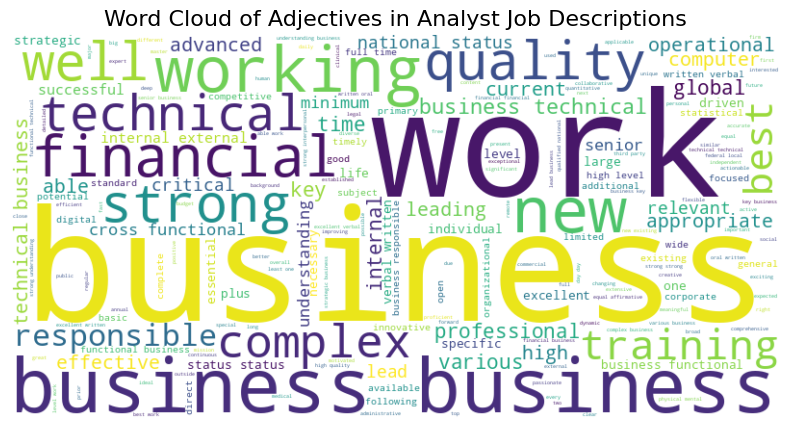

In [40]:
# Q6: Create a wordcloud image out of the filtered words (pip install wordcloud).
# What are the main capabilities one must posses in order to hold an Analyst position in the US?

from wordcloud import WordCloud

all_adjectives = [adj for sublist in df['adjectives'] for adj in sublist]

# Combining the list of adjectives into a single string
adjectives_text = ' '.join(all_adjectives)

# Creating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='viridis', max_words=200).generate(adjectives_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Adjectives in Analyst Job Descriptions', fontsize=16)
plt.show()


**What are the main capabilities one must posses in order to hold an Analyst position in the US?**\
Based on the word cloud, the primary capabilities highlighted in job descriptions for Analyst positions in the US include:

1. **Business**: The word "business" appears prominently, indicating that analysts are often required to have a strong understanding of business processes, goals, and functions.
2. **Work-related skills**: Words like "work," "working," and "responsible" suggest that analysts need to demonstrate strong work ethic, accountability, and the ability to manage their workload effectively.
3. **Technical expertise**: The frequent appearance of "technical" highlights the importance of technical skills, likely including data analysis, software tools, or domain-specific knowledge.
4. **Financial and analytical skills**: Words such as "financial" and "quality" suggest that analysts are expected to have the ability to assess financial data or produce high-quality reports.
5. **Global and strategic thinking**: The presence of terms like "global," "strategic," and "complex" suggests that analysts often work in roles requiring broader thinking, strategic analysis, and problem-solving across multiple contexts.
6. **Soft skills and adaptability**: Words like "strong," "new," and "various" reflect the need for flexibility, leadership, and communication skills to succeed in dynamic environments.

Therefore, an Analyst in the US must possess a combination of **business understanding, technical expertise, financial understanding, and adaptability** to thrive in their role.

**Explain your approach and assumptions once this section is completed.**

**Q1:** First, we count the occurrences of each job title in the DataFrame to identify the most common titles. Then, we select the top 10 job titles and create a pie chart to visualize their distribution. The pie chart is styled with color mapping and a legend showing the percentage of each title. Finally, we extract and print the two most popular job titles from the top 10.\
**Q2:** We start by filtering the dataset to include only the top 10 cities based on job postings. Next, we create three scatter plots to analyze the relationship between job ratings and three variables: expected salary, company size, and city. Each plot is labeled appropriately, and the layout is adjusted for clarity before displaying the plots.\
**Q3:** We prepare the data by converting relevant columns (like expected salary and company size) to numeric values and filtering out rows with missing values. Using Pearson correlation from the SciPy library, we calculate the correlation coefficients between job ratings and the three variables of interest: expected salary, company size, and encoded city values. The results are printed to assess the strength of these correlations.\
**Q5:** To extract adjectives, we load a list of common stopwords and a list of adjectives from an external file. We define a function that processes job descriptions to filter out irrelevant words and keep only adjectives. This function is applied to the 'Job Description' column in the DataFrame, creating a new column containing lists of adjectives. The original job descriptions and their extracted adjectives are then displayed for review.\
**Q6:** We compile all the extracted adjectives into a single string suitable for visualization. Using the WordCloud library, we generate a word cloud that highlights the most common adjectives found in the job descriptions. The word cloud is then displayed, providing a visual representation of the key attributes associated with analyst positions in the dataset.

# 4. Covid in the US
In this question, you are required to reproduce the graphs shown in a real journalistic article. After all, reproducibility is an important part of professional journalism as well as data science. Also, a great deal of a data scientist's work is to communicate data in a way that anyone with any level of expertise in the field would understand.

You should reproduce the 4 graphs shown in <a href="https://projects.fivethirtyeight.com/coronavirus-polls/"> this article</a>. The data is openly accessible through <a href="https://github.com/fivethirtyeight/covid-19-polls/"> FiveThirtyEight's github</a>. Nevertheless, both the data and the article are available in `data` folder in case of unstable internet connections!

*Note: Your graphs don't have to be as interactive or detailed as the ones on the website. Only showing the averages, some (not all) data points with light color, legends, titles, x values, and y values are necessary.*

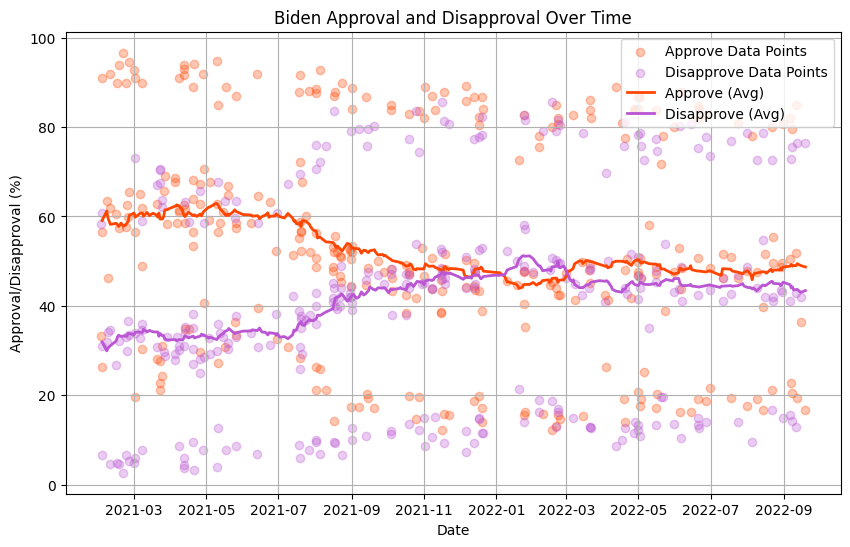

In [42]:
# Do Americans approve of Biden’s response to the coronavirus crisis?

df = pd.read_csv('covid_approval_polls_adjusted.csv')
df['enddate'] = pd.to_datetime(df['enddate'])
df_biden = df[df['subject'] == 'Biden']
approval_data = df_biden[['enddate', 'approve_adjusted', 'disapprove_adjusted']]

# Daily data: (mean value per day)
approval_data.set_index('enddate', inplace=True)
daily_mean = approval_data.resample('D').mean().dropna()
# We applied a rolling average to smooth out the data: (over a week)
window_size = 7
daily_mean_smooth = daily_mean.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
sampled_data = approval_data.sample(frac=0.2, random_state=42)  # 20% random sampling
plt.scatter(sampled_data.index, sampled_data['approve_adjusted'], color='orangered', alpha=0.3, label='Approve Data Points')
plt.scatter(sampled_data.index, sampled_data['disapprove_adjusted'], color='mediumorchid', alpha=0.3, label='Disapprove Data Points')

plt.plot(daily_mean_smooth.index, daily_mean_smooth['approve_adjusted'], color='orangered', label='Approve (Avg)', linewidth=2)
plt.plot(daily_mean_smooth.index, daily_mean_smooth['disapprove_adjusted'], color='mediumorchid', label='Disapprove (Avg)', linewidth=2)

plt.title('Biden Approval and Disapproval Over Time')
plt.xlabel('Date')
plt.ylabel('Approval/Disapproval (%)')
plt.legend()
plt.grid(True)
plt.show()

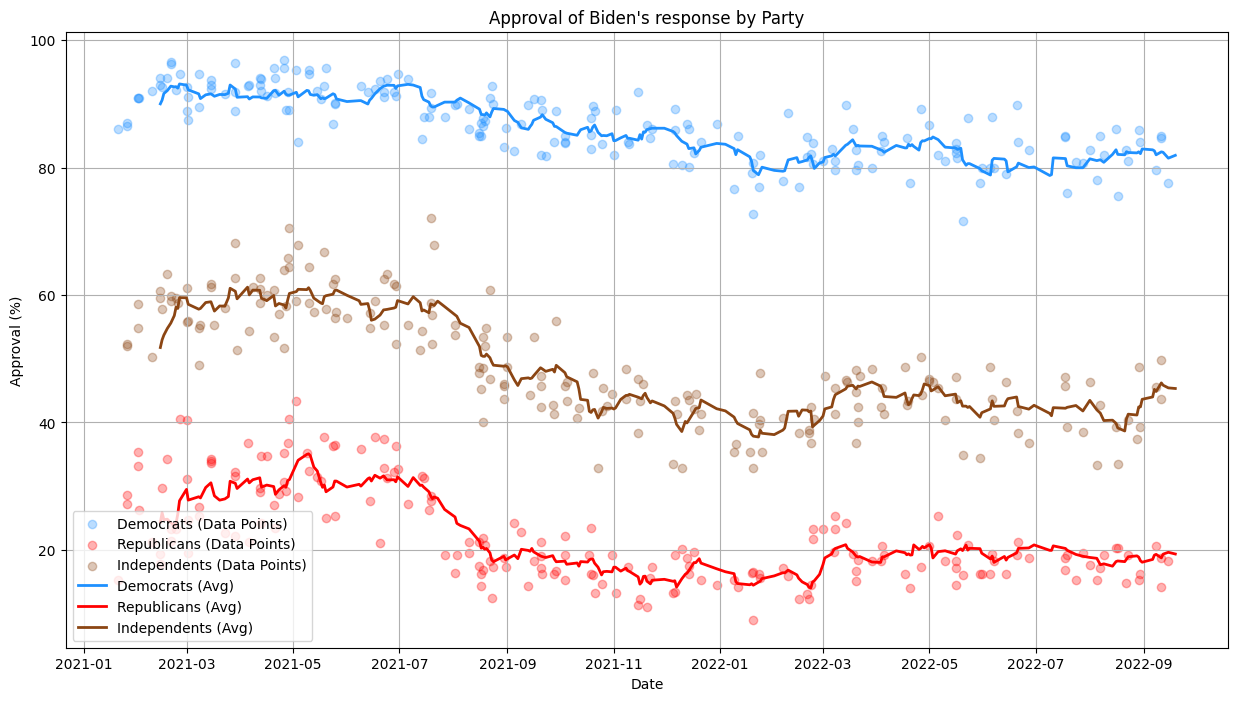

In [43]:
# Approval of Biden’s response varies widely by party

df = pd.read_csv('covid_approval_polls_adjusted.csv')
df['enddate'] = pd.to_datetime(df['enddate'])
df_biden = df[df['subject'] == 'Biden']

df_ds = df_biden[df_biden['party'] == 'D']
df_rs = df_biden[df_biden['party'] == 'R']
df_is = df_biden[df_biden['party'] == 'I']

df_ds.set_index('enddate', inplace=True)
df_rs.set_index('enddate', inplace=True)
df_is.set_index('enddate', inplace=True)

sampled_ds = df_ds.sample(frac=0.5, random_state=42)
sampled_rs = df_rs.sample(frac=0.5, random_state=42)
sampled_is = df_is.sample(frac=0.5, random_state=42)

plt.figure(figsize=(15, 8))
plt.scatter(sampled_ds.index, sampled_ds['approve_adjusted'], color='dodgerblue', alpha=0.3, label='Democrats (Data Points)')
plt.scatter(sampled_rs.index, sampled_rs['approve_adjusted'], color='red', alpha=0.3, label='Republicans (Data Points)')
plt.scatter(sampled_is.index, sampled_is['approve_adjusted'], color='saddlebrown', alpha=0.3, label='Independents (Data Points)')

daily_mean_ds = df_ds['approve_adjusted'].resample('D').mean().dropna()
daily_mean_rs = df_rs['approve_adjusted'].resample('D').mean().dropna()
daily_mean_is = df_is['approve_adjusted'].resample('D').mean().dropna()

# We applied a rolling average to smooth out the data: (over a week)
window_size = 7
daily_mean_ds_smooth = daily_mean_ds.rolling(window=window_size).mean()
daily_mean_rs_smooth = daily_mean_rs.rolling(window=window_size).mean()
daily_mean_is_smooth = daily_mean_is.rolling(window=window_size).mean()

plt.plot(daily_mean_ds_smooth.index, daily_mean_ds_smooth, color='dodgerblue', label='Democrats (Avg)', linewidth=2)
plt.plot(daily_mean_rs_smooth.index, daily_mean_rs_smooth, color='red', label='Republicans (Avg)', linewidth=2)
plt.plot(daily_mean_is_smooth.index, daily_mean_is_smooth, color='saddlebrown', label='Independents (Avg)', linewidth=2)

plt.title('Approval of Biden\'s response by Party')
plt.xlabel('Date')
plt.ylabel('Approval (%)')
plt.legend()
plt.grid(True)

plt.show()

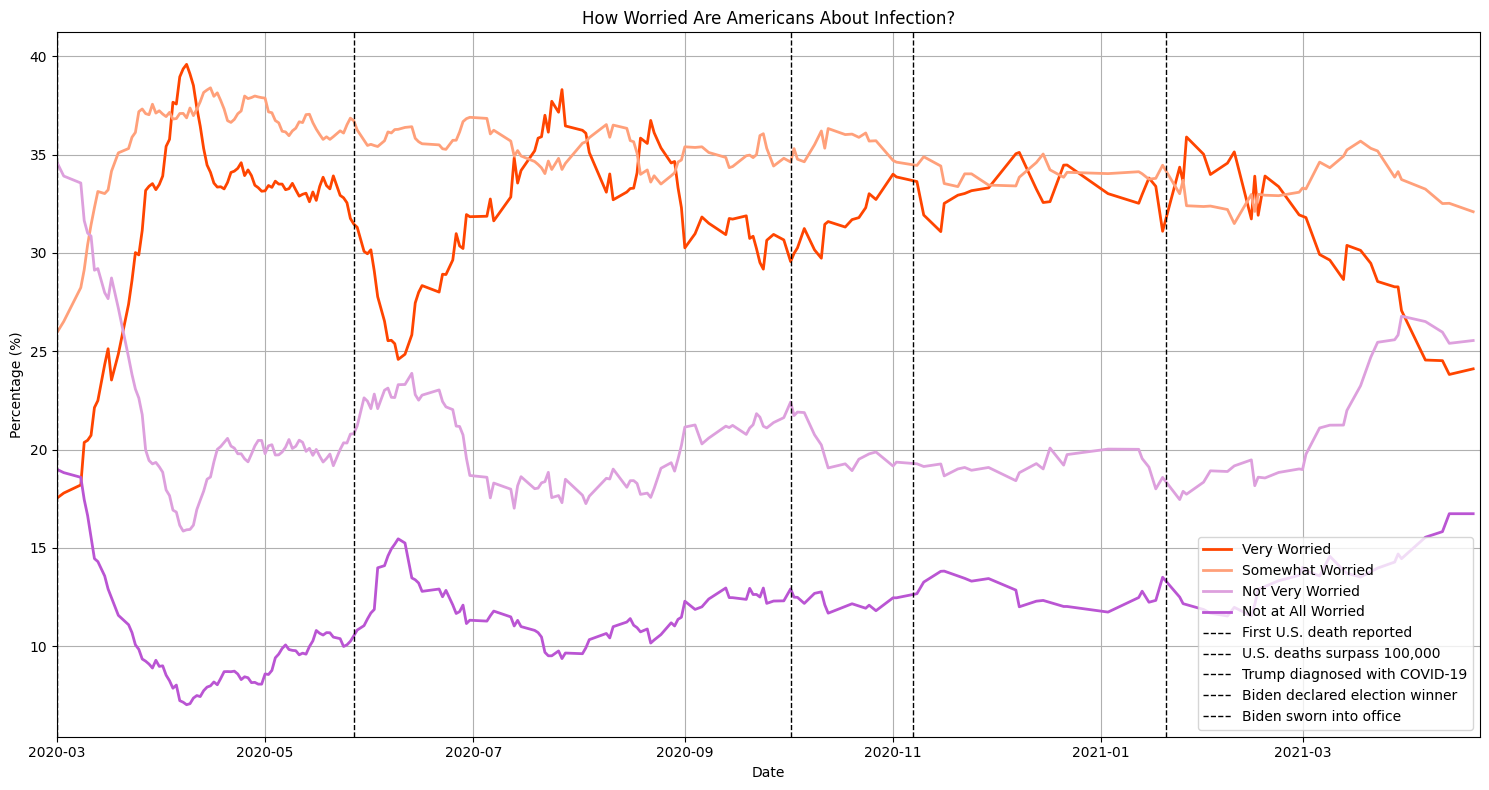

In [45]:
# How worried are Americans about infection?

df = pd.read_csv('covid_concern_polls_adjusted.csv')
df['enddate'] = pd.to_datetime(df['enddate'])
df_infected = df[df['subject'] == 'concern-infected']
df_infected.set_index('enddate', inplace=True)

daily_mean_very = df_infected['very_adjusted'].resample('D').mean().dropna()
daily_mean_somewhat = df_infected['somewhat_adjusted'].resample('D').mean().dropna()
daily_mean_not_very = df_infected['not_very_adjusted'].resample('D').mean().dropna()
daily_mean_not_at_all = df_infected['not_at_all_adjusted'].resample('D').mean().dropna()

# We applied a rolling average to smooth out the data: (over a week)
window_size = 7
daily_mean_very_smooth = daily_mean_very.rolling(window=window_size).mean()
daily_mean_somewhat_smooth = daily_mean_somewhat.rolling(window=window_size).mean()
daily_mean_not_very_smooth = daily_mean_not_very.rolling(window=window_size).mean()
daily_mean_not_at_all_smooth = daily_mean_not_at_all.rolling(window=window_size).mean()

plt.figure(figsize=(15, 8))
plt.plot(daily_mean_very_smooth.index, daily_mean_very_smooth, color='orangered', label='Very Worried', linewidth=2)
plt.plot(daily_mean_somewhat_smooth.index, daily_mean_somewhat_smooth, color='lightsalmon', label='Somewhat Worried', linewidth=2)
plt.plot(daily_mean_not_very_smooth.index, daily_mean_not_very_smooth, color='plum', label='Not Very Worried', linewidth=2)
plt.plot(daily_mean_not_at_all_smooth.index, daily_mean_not_at_all_smooth, color='mediumorchid', label='Not at All Worried', linewidth=2)

plt.axvline(pd.Timestamp('2020-03-01'), color='black', linestyle='--', linewidth=1, label='First U.S. death reported')
plt.axvline(pd.Timestamp('2020-05-27'), color='black', linestyle='--', linewidth=1, label='U.S. deaths surpass 100,000')
plt.axvline(pd.Timestamp('2020-10-02'), color='black', linestyle='--', linewidth=1, label='Trump diagnosed with COVID-19')
plt.axvline(pd.Timestamp('2020-11-07'), color='black', linestyle='--', linewidth=1, label='Biden declared election winner')
plt.axvline(pd.Timestamp('2021-01-20'), color='black', linestyle='--', linewidth=1, label='Biden sworn into office')

plt.xlim(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-04-22'))
plt.title('How Worried Are Americans About Infection?')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

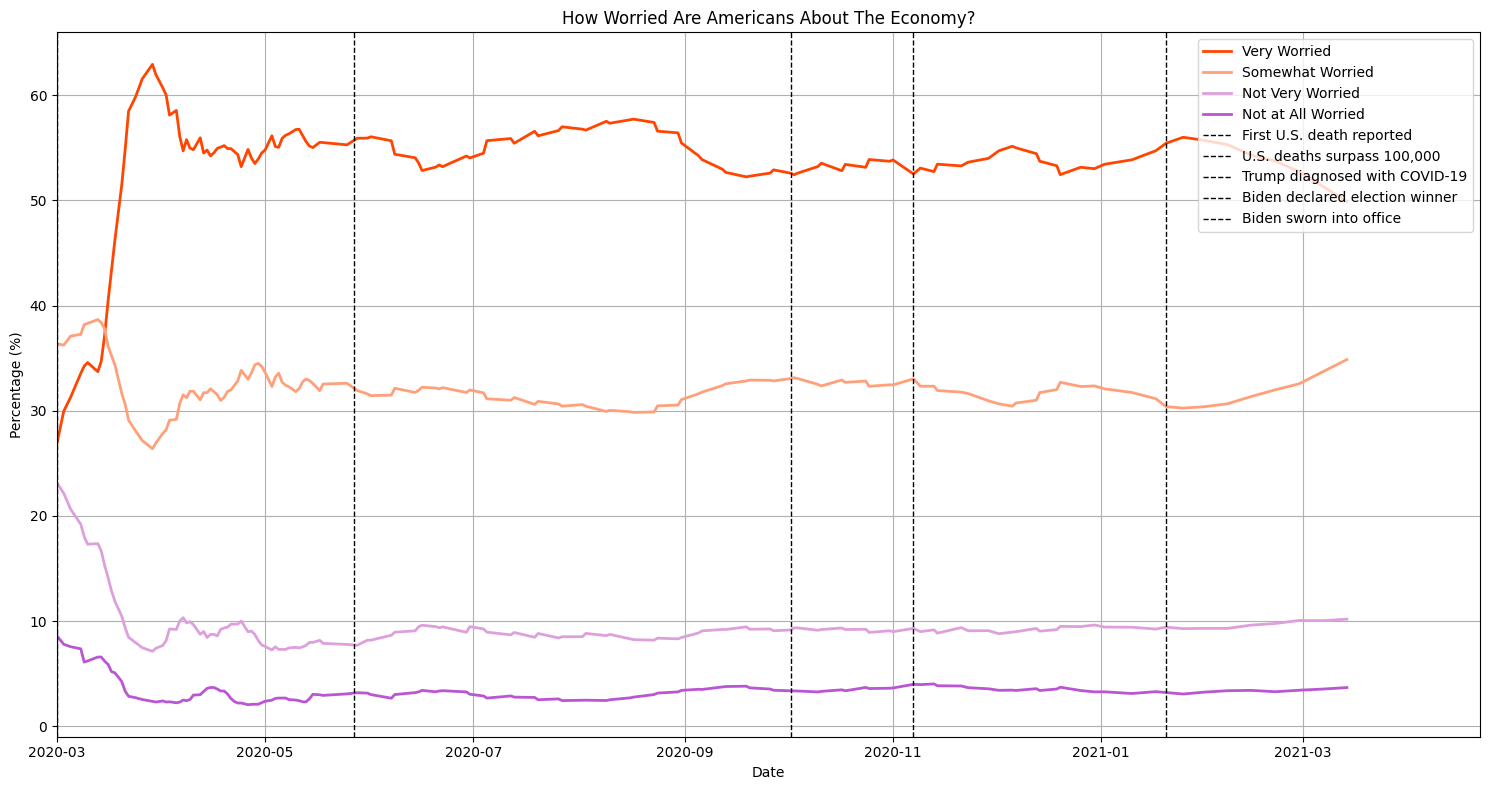

In [46]:
# How worried are Americans about the economy?

df = pd.read_csv('covid_concern_polls_adjusted.csv')
df['enddate'] = pd.to_datetime(df['enddate'])
df_economy = df[df['subject'] == 'concern-economy']
df_economy.set_index('enddate', inplace=True)

daily_mean_very = df_economy['very_adjusted'].resample('D').mean().dropna()
daily_mean_somewhat = df_economy['somewhat_adjusted'].resample('D').mean().dropna()
daily_mean_not_very = df_economy['not_very_adjusted'].resample('D').mean().dropna()
daily_mean_not_at_all = df_economy['not_at_all_adjusted'].resample('D').mean().dropna()

# We applied a rolling average to smooth out the data: (over a week)
window_size = 7
daily_mean_very_smooth = daily_mean_very.rolling(window=window_size).mean()
daily_mean_somewhat_smooth = daily_mean_somewhat.rolling(window=window_size).mean()
daily_mean_not_very_smooth = daily_mean_not_very.rolling(window=window_size).mean()
daily_mean_not_at_all_smooth = daily_mean_not_at_all.rolling(window=window_size).mean()

plt.figure(figsize=(15, 8))
plt.plot(daily_mean_very_smooth.index, daily_mean_very_smooth, color='orangered', label='Very Worried', linewidth=2)
plt.plot(daily_mean_somewhat_smooth.index, daily_mean_somewhat_smooth, color='lightsalmon', label='Somewhat Worried', linewidth=2)
plt.plot(daily_mean_not_very_smooth.index, daily_mean_not_very_smooth, color='plum', label='Not Very Worried', linewidth=2)
plt.plot(daily_mean_not_at_all_smooth.index, daily_mean_not_at_all_smooth, color='mediumorchid', label='Not at All Worried', linewidth=2)

plt.axvline(pd.Timestamp('2020-03-01'), color='black', linestyle='--', linewidth=1, label='First U.S. death reported')
plt.axvline(pd.Timestamp('2020-05-27'), color='black', linestyle='--', linewidth=1, label='U.S. deaths surpass 100,000')
plt.axvline(pd.Timestamp('2020-10-02'), color='black', linestyle='--', linewidth=1, label='Trump diagnosed with COVID-19')
plt.axvline(pd.Timestamp('2020-11-07'), color='black', linestyle='--', linewidth=1, label='Biden declared election winner')
plt.axvline(pd.Timestamp('2021-01-20'), color='black', linestyle='--', linewidth=1, label='Biden sworn into office')

plt.xlim(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-04-22'))
plt.title('How Worried Are Americans About The Economy?')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Explain your approach and assumptions once this section is completed.**

**Part 1: Do Americans approve of Biden’s response to the coronavirus crisis?**\
We load the dataset covid_approval_polls_adjusted.csv using pandas. This dataset contains public approval and disapproval ratings of Biden and Trump related to their response to the coronavirus pandemic. The data is filtered to focus solely on Biden’s approval ratings by selecting rows where the 'subject' column equals 'Biden'.\
The enddate column, (the date the poll ended), is converted to a datetime format using pd.to_datetime() to allow for time-based operations.\
We created a subset of the dataframe to include only the relevant columns: 'enddate', 'approve_adjusted', and 'disapprove_adjusted'.\
The enddate column is set as the index to make it easier to perform resampling based on dates.\
To handle potential inconsistencies in the frequency of polls (e.g., multiple polls on the same day or no polls on some days), we resampled the data to daily frequency using resample('D') and calculating the daily mean of approval and disapproval ratings.\
A rolling window of 7 days (weekly average) is applied to smooth out the fluctuations in the data, creating a clearer trend.\
To avoid over-plotting all the data points (since the dataset might be large), we chose a random 20% sample of the data points to plot.

**Part 2: Approval of Biden’s response varies widely by party**\
We start by loading the dataset covid_approval_polls_adjusted.csv using the pandas library. This dataset contains various polls regarding public approval ratings of political figures, including Biden. The 'enddate' column, which indicates when the poll was conducted, is converted to a datetime format to facilitate time-based operations. We filter the dataset to only include rows related to Biden by selecting entries where the 'subject' column equals 'Biden'. We further segment the dataset based on party affiliation:
Democrats (D)
Republicans (R)
Independents (I)
Each subset is created by filtering the main df_biden DataFrame according to the 'party' column.
For each party-specific DataFrame, we set the 'enddate' column as the index to simplify the resampling and plotting processes.To reduce the number of data points and avoid clutter in the visualization, we take a random 50% sample from each party's DataFrame. We create a scatter plot to visualize the sampled approval ratings for each political party. Each party is represented by a different color. We calculate the daily mean approval ratings for each political party using the resample() method. This allows us to aggregate the data based on daily frequency, dropping any rows with missing values. To smooth out fluctuations in the data, we apply a rolling average with a window size of 7 days for each party’s daily mean approval ratings. Finally, we plot the smoothed daily mean approval ratings for each party, using distinct colors for each group to enhance clarity.

**Part 3: How worried are Americans about infection?**\
The dataset covid_concern_polls_adjusted.csv is loaded into a Pandas DataFrame.
The 'enddate' column, which represents the date of each poll, is converted to a datetime format for easier manipulation.
A subset of the DataFrame is created to focus on concerns specifically related to infection by filtering for rows where the 'subject' column equals 'concern-infected'.
The 'enddate' column is set as the index to facilitate time-based analysis. The code calculates the daily average of different levels of concern regarding infection:
very_adjusted: Percentage of respondents who are "very worried."
somewhat_adjusted: Percentage of respondents who are "somewhat worried."
not_very_adjusted: Percentage of respondents who are "not very worried."
not_at_all_adjusted: Percentage of respondents who are "not at all worried."
The resample('D') method groups the data by day, and the mean() function calculates the average concern level for each day.
dropna() is used to remove any days that have no data available.
A rolling average with a window size of 7 days is applied to each of the daily mean values to smooth out short-term fluctuations and provide a clearer view of trends over time.
A line plot is created to visualize the smoothed daily averages for the different levels of concern.
Each line is assigned a specific color and labeled accordingly for clarity.
Vertical lines are added to the plot to mark significant dates relevant to the COVID-19 pandemic in the U.S., such as the first reported death and the number of deaths surpassing 100,000.
These lines help provide context for the data by indicating important events that may have influenced public concern.

**Part 4: How worried are Americans about the economy?**\
The dataset covid_concern_polls_adjusted.csv is loaded into a Pandas DataFrame.
The 'enddate' column, which indicates when each poll was conducted, is converted to a datetime format for easier time series analysis.
A subset of the DataFrame is created to focus specifically on concerns related to the economy by filtering for rows where the 'subject' column equals 'concern-economy'.
The 'enddate' column is set as the index to facilitate time-based operations.
The code calculates the daily average for different levels of concern about the economy:
very_adjusted: Percentage of respondents who are "very worried" about the economy.
somewhat_adjusted: Percentage of respondents who are "somewhat worried."
not_very_adjusted: Percentage of respondents who are "not very worried."
not_at_all_adjusted: Percentage of respondents who are "not at all worried."
The resample('D') method is used to group the data by day, and the mean() function computes the average level of concern for each day.
dropna() is called to remove any days that do not have recorded data.
A rolling average with a window size of 7 days is applied to the daily mean values for each category of concern to smooth out daily fluctuations and better reveal trends over time.
A line plot is created to visualize the smoothed daily averages of Americans' concerns about the economy.
Each line represents a specific level of concern, distinguished by different colors and labels for clarity.
Vertical dashed lines are added to indicate significant dates during the pandemic, such as the first reported COVID-19 death and when U.S. deaths surpassed 100,000.
These lines help contextualize the sentiment data by marking important events that may have influenced public concern about the economy.